In [1]:
using PyPlot
using PyCall
using Peaks
np=pyimport("numpy")
eV = 27.2114; #Hartree to eV conversion
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 15
rcParams["legend.fontsize"] = "small"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.titlesize"] = "xx-large"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "sans-serif"
rcParams["figure.figsize"] = (6, 6);

In [2]:
dir_nohybrid = string(pwd(), "/nohybrid");

In [3]:
#Loop over all simulations and store the band indices and oscillator strengths corresponding to the 
#relevant green and red transitions. 
AllValidPairsGreen = Vector{Tuple{String, Vector{Tuple{Integer, Integer, Integer, Float64}}}}()
# Vector of tuples of the form: (ID, (spin, lowerband, upperband, oscillator strength))
AllValidPairsRed = Vector{Tuple{String, Vector{Tuple{Integer, Integer, Integer, Float64}}}}()
# Vector of tuples of the form: (ID, (spin, lowerband, upperband, oscillator strength))
#in the end since we have no phase interfering terms. 
transitioneigenvals = Float64[]
for (i, j) in Tuple.(CartesianIndices(rand(4, 5)))
    id="$(i)$(j)"
    μ=0 
    (isfile("$dir_nohybrid/STH2$(id).eigStats") && isfile("$dir_nohybrid/STH2$(id).momenta") && isfile("$dir_nohybrid/STH2$(id).eigenvals")) || continue
    for l in readlines("$dir_nohybrid/STH2$(id).eigStats")
        if VERSION.minor >= 5  
            contains(l, "mu" ) || continue ;
        elseif VERSION.minor < 5
            occursin("mu", l) || continue ;
        end
        μ = parse(Float64, l[6:end]);
    end
    eigenvalsup = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[1:48]*eV
    eigenvalsdn = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[49:96]*eV
    momenta = np.reshape(abs.(np.fromfile("$dir_nohybrid/STH2$(id).momenta", dtype=np.complex )), (2, 3, 48, 48));
    (permutedims(momenta, (1, 2, 4, 3)) ≈ conj(momenta)) || error("Momenta Do Not Satisfy Hermiticity Condition")

    ValidPairsGreen = Vector{Tuple{Integer, Integer, Integer, Float64}}() 
    ValidPairsRed = Vector{Tuple{Integer, Integer, Integer, Float64}}() 

    for spin in [1, 2]
        transitioneigenvals = (spin == 1) ? eigenvalsup : eigenvalsdn
        for (i, e) in enumerate(transitioneigenvals)
            for (j, eprime) in enumerate(transitioneigenvals)
                (i > 10 && j> 10 ) || continue
                (i < 30 && j < 30) || continue
                if (2.1 < abs(e-eprime) < 2.3)
                    #Note that we must convert back from eV to hartree, so the denominator is divided by 27.2
                    !((j, i) in [v[2:3] for v in ValidPairsGreen]) && push!(ValidPairsGreen, (spin, i, j, eV*2/3*sum((abs.(momenta[spin, :, i, j])).^2)/abs(e-eprime) ))
                elseif (1.7 < abs(e-eprime) < 1.9)
                    !((j, i) in [v[2:3] for v in ValidPairsRed]) && push!(ValidPairsRed, (spin, i, j, eV*2/3*sum((abs.(momenta[spin, :, i, j])).^2)/abs(e-eprime)))
                end
            end
        end
    end
    push!(AllValidPairsGreen, (id, ValidPairsGreen))
    push!(AllValidPairsRed, (id, ValidPairsRed))
end


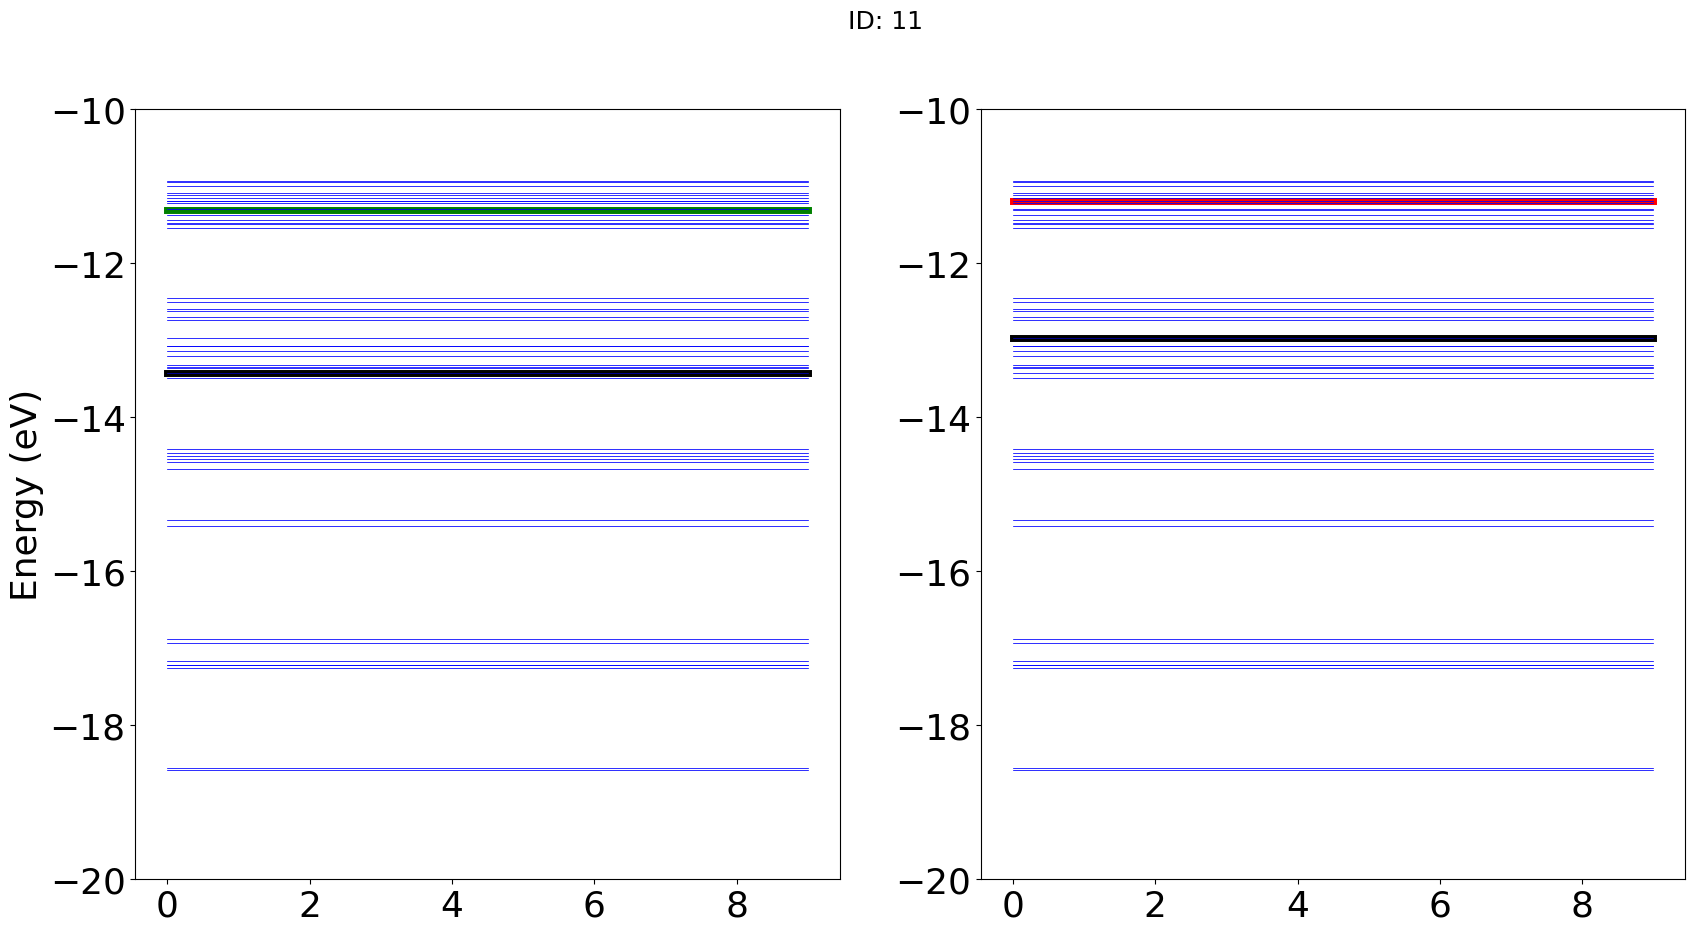

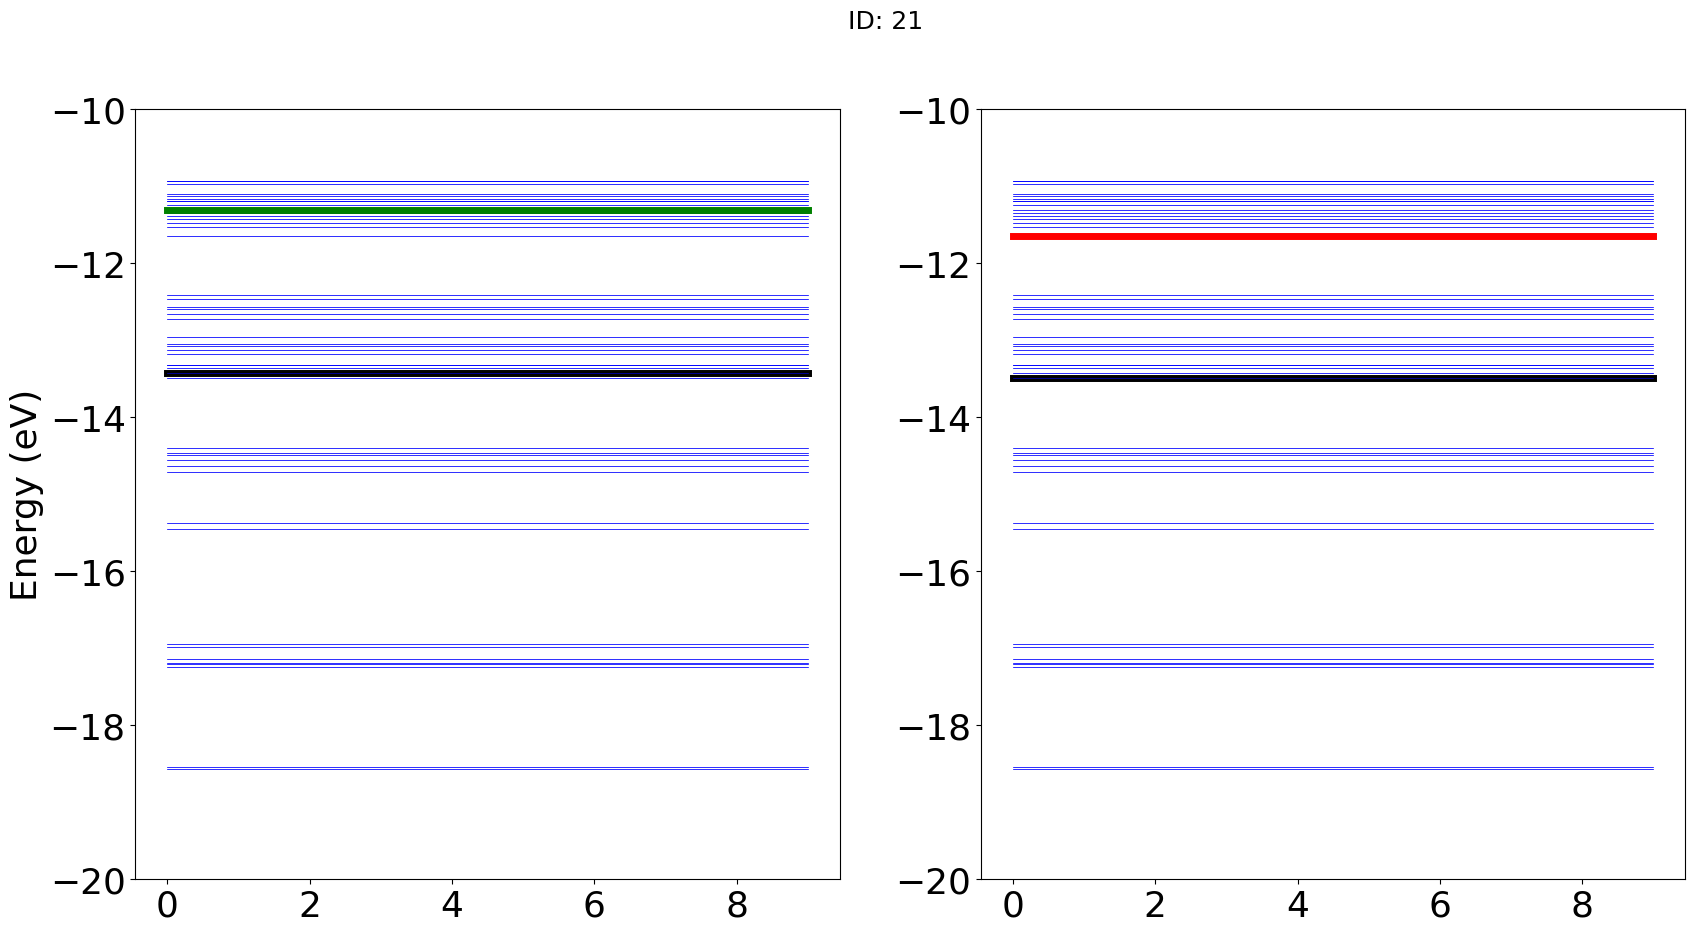

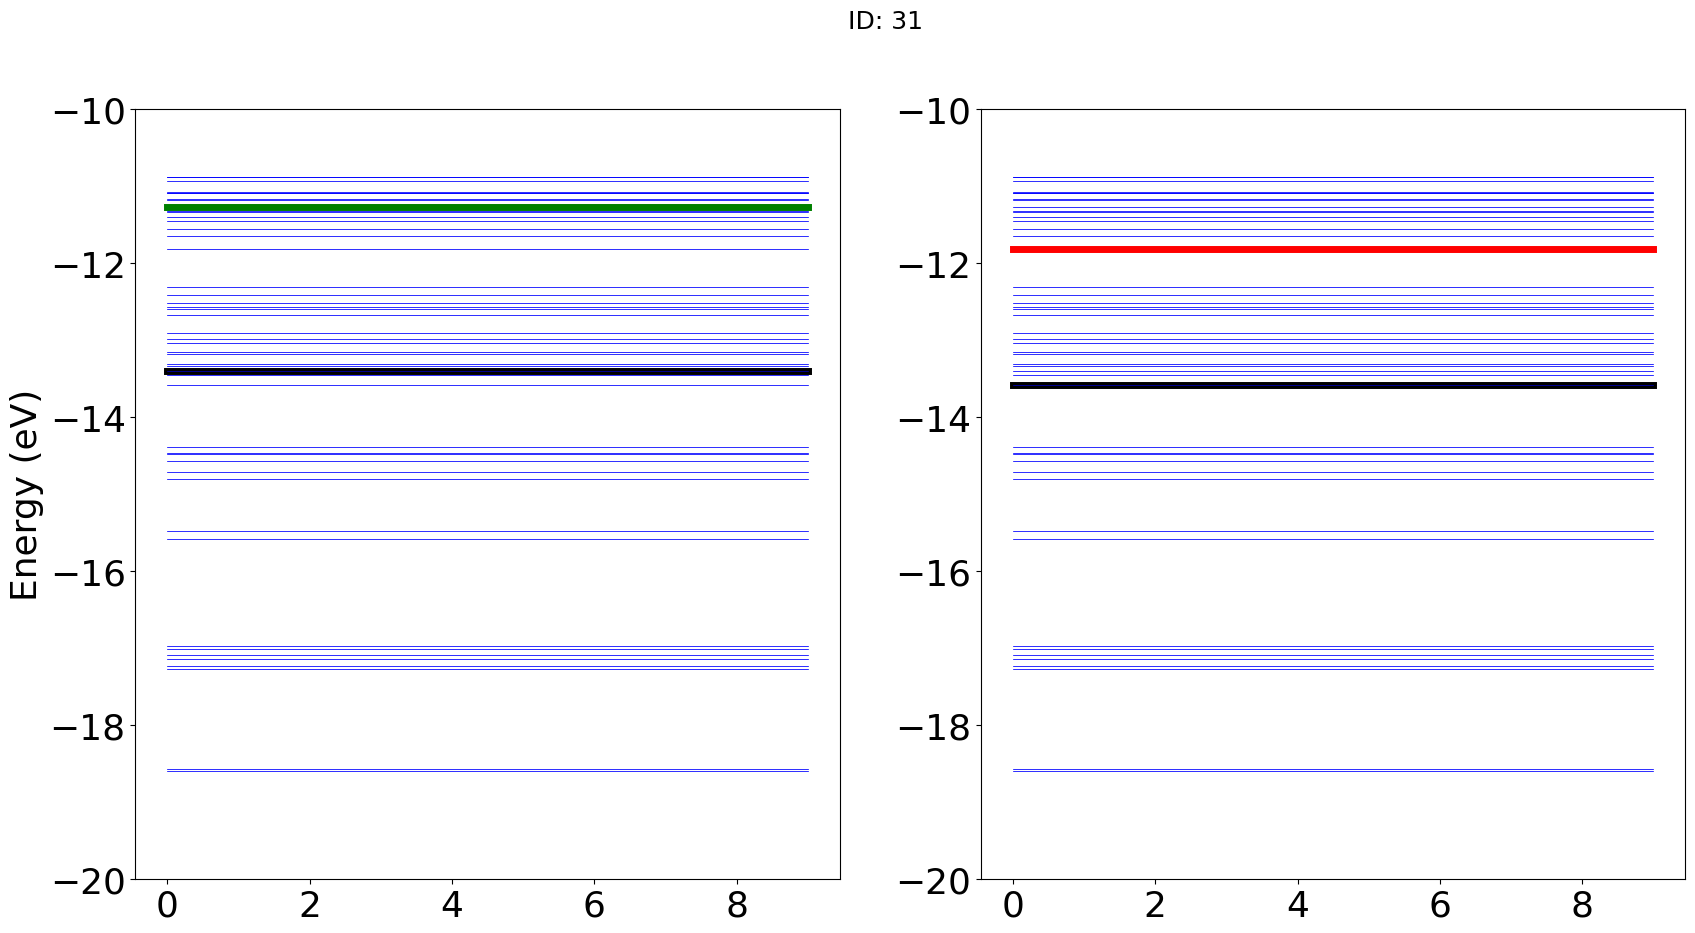

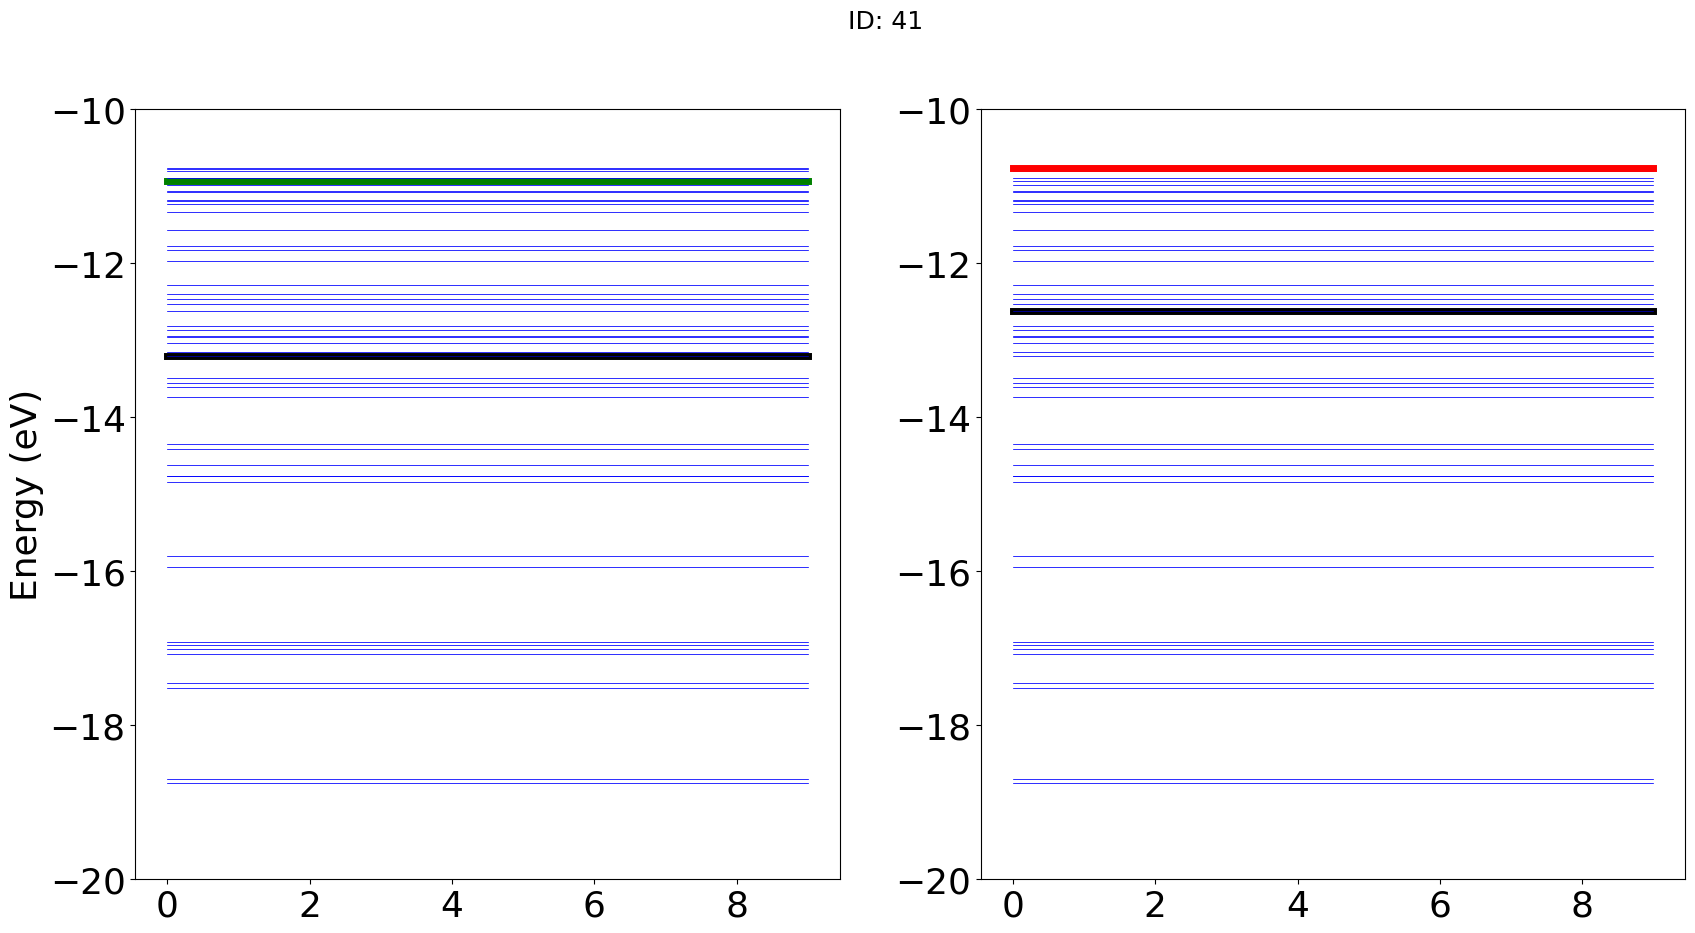

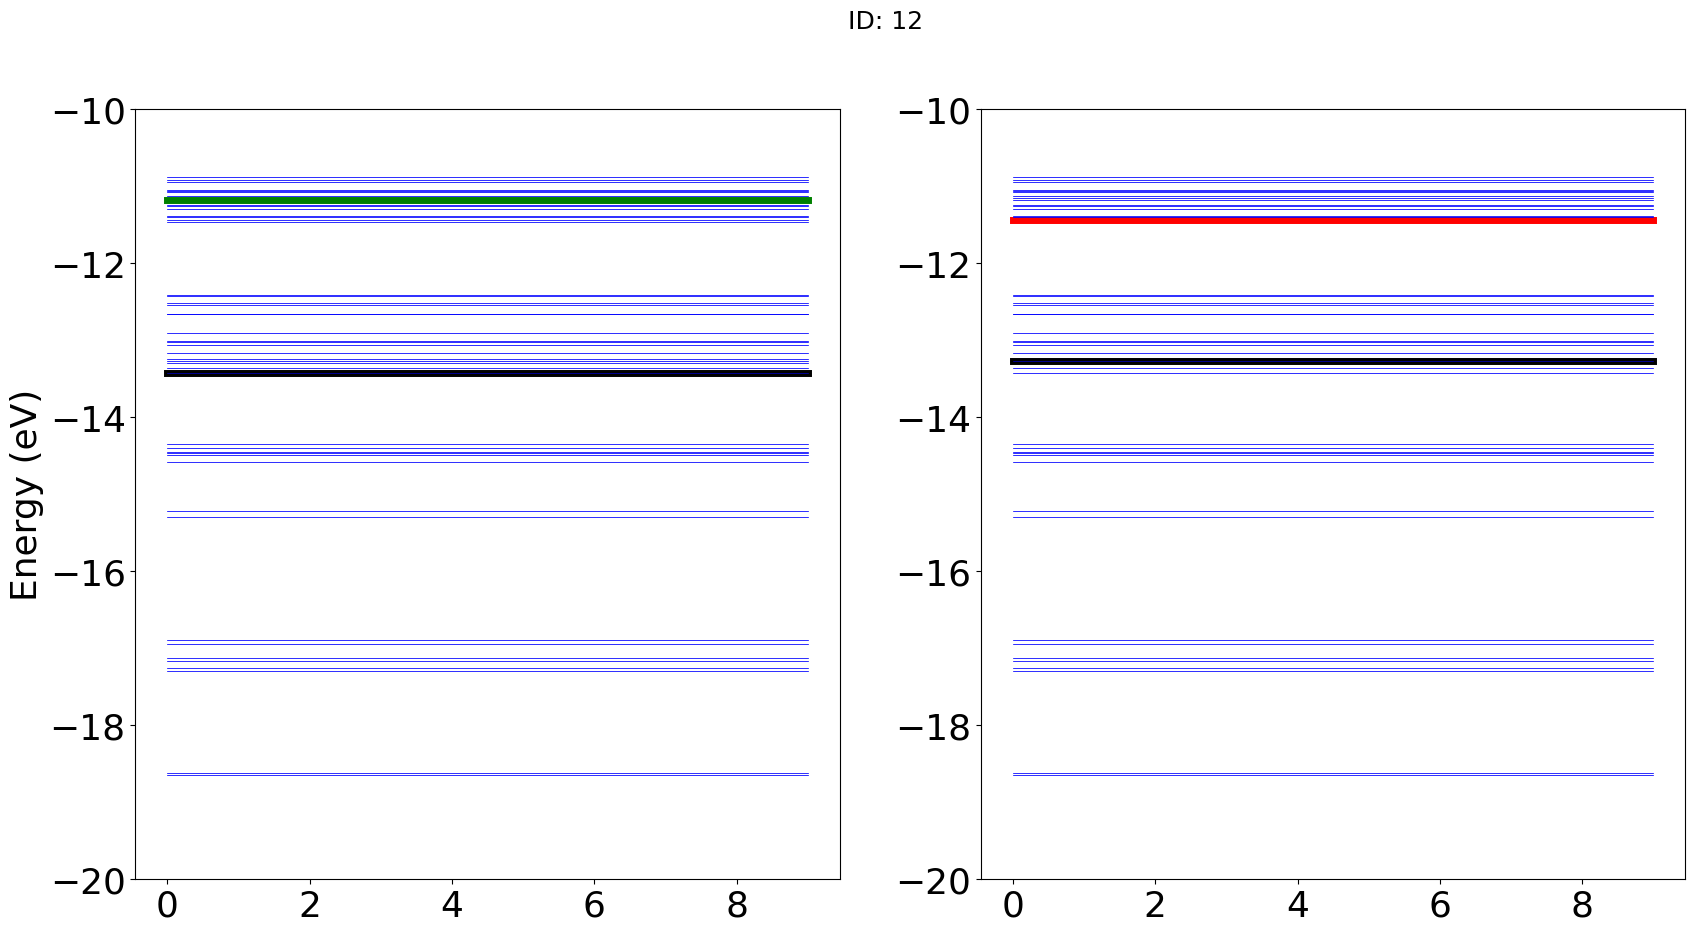

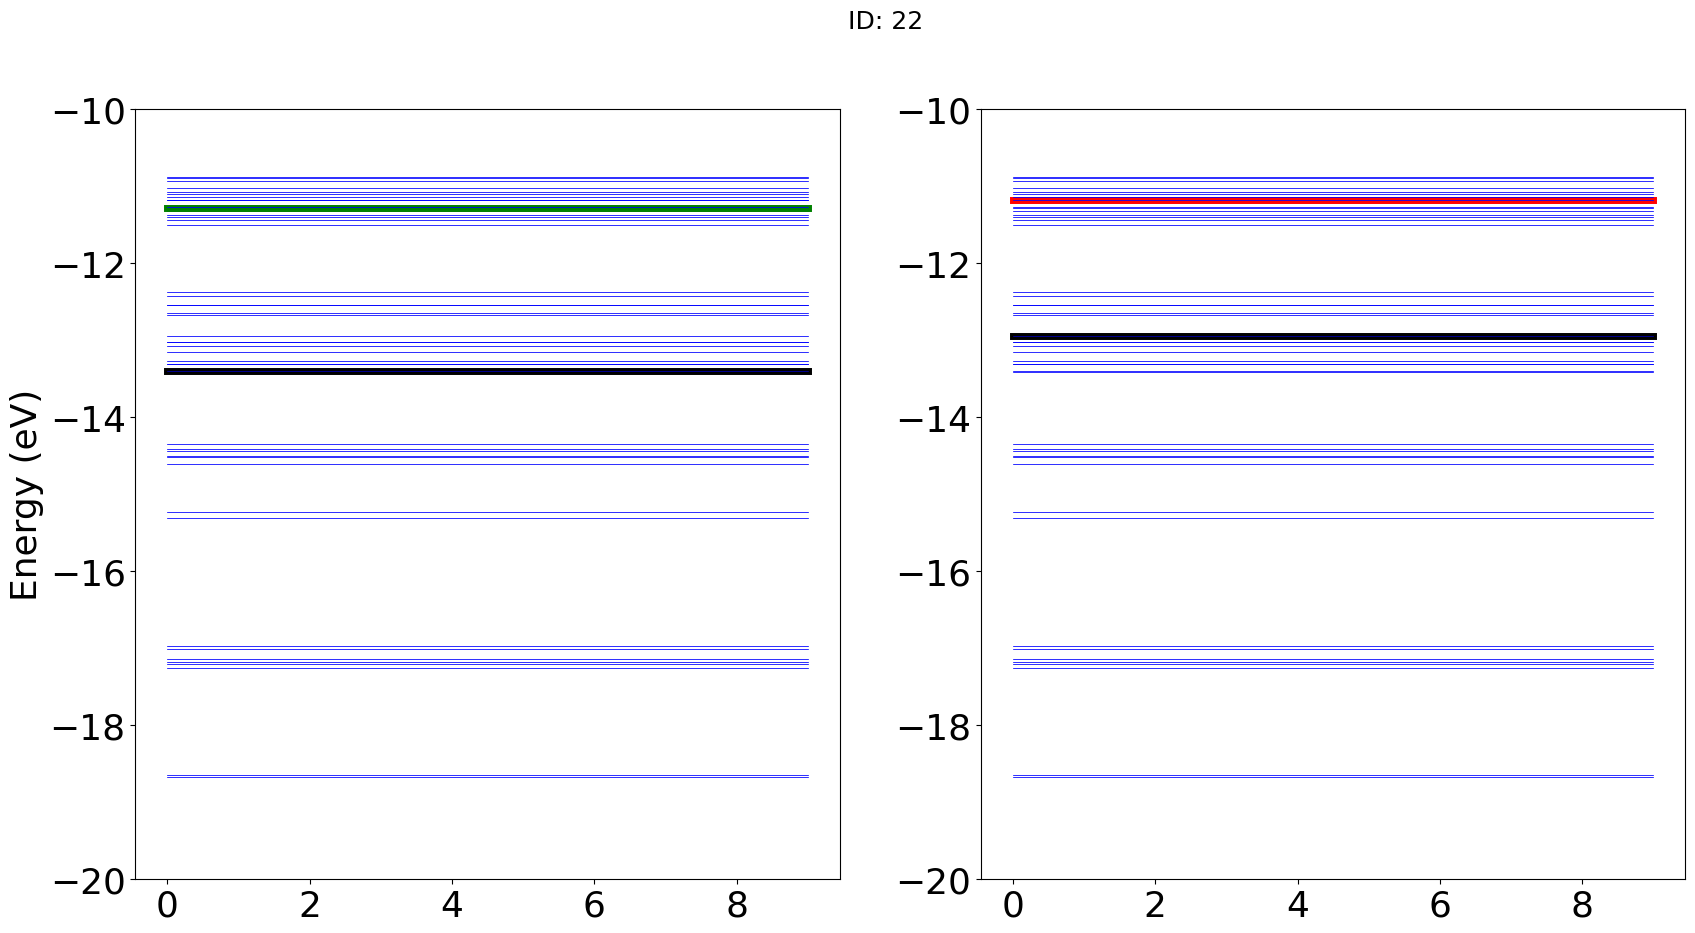

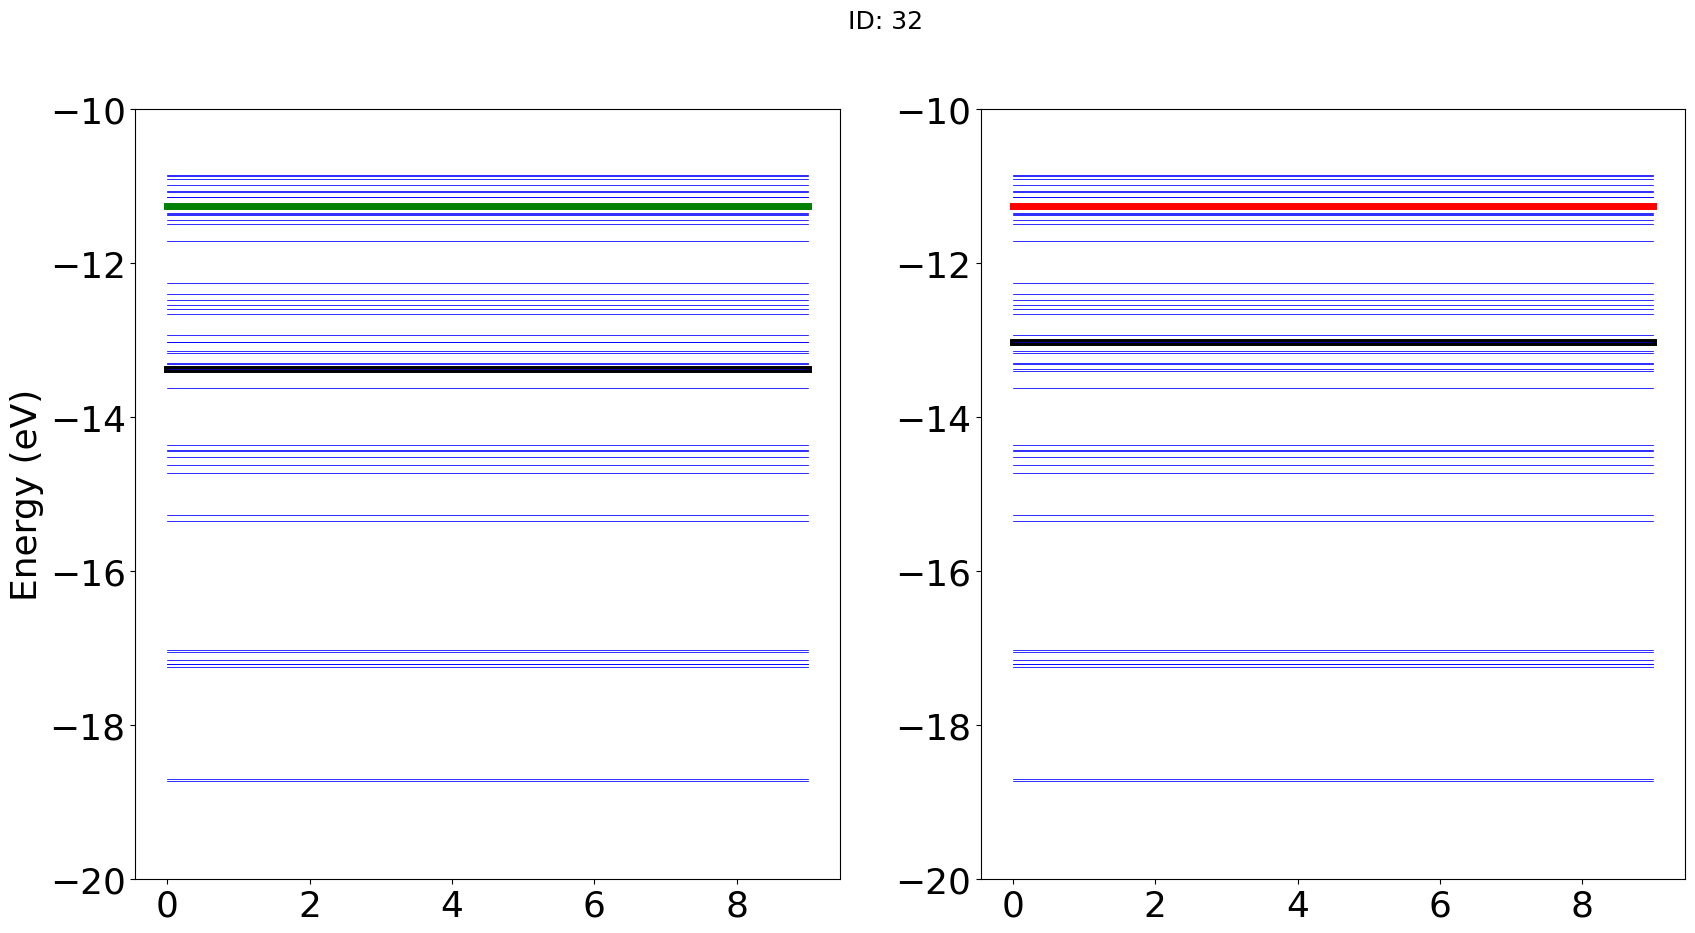

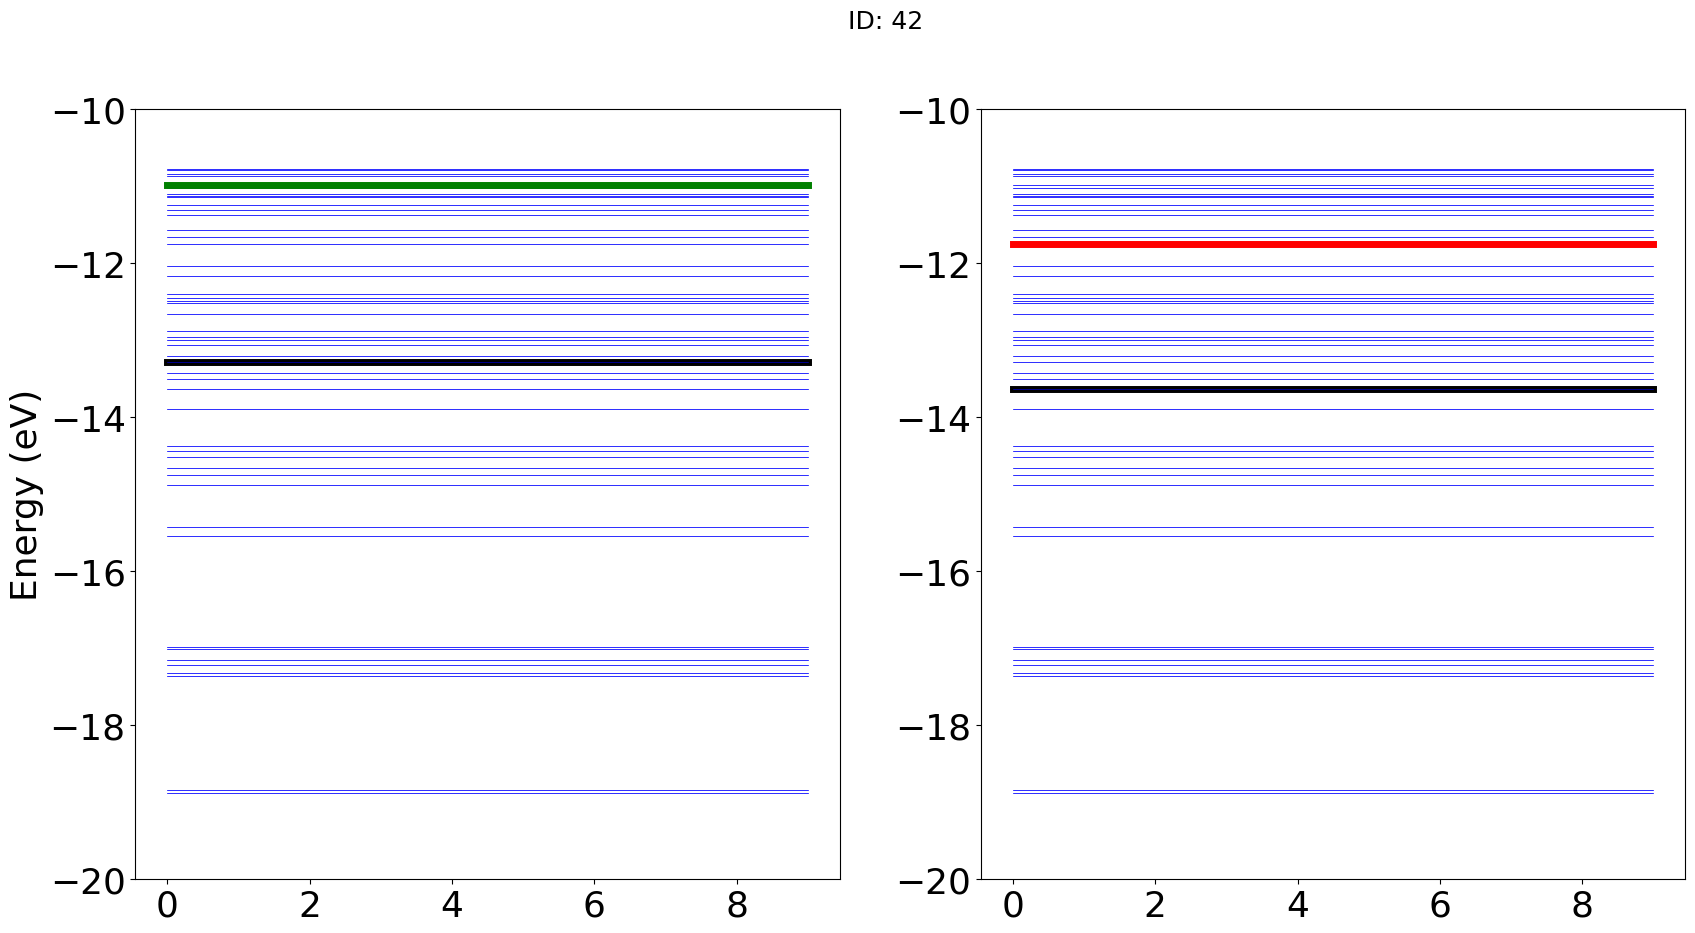

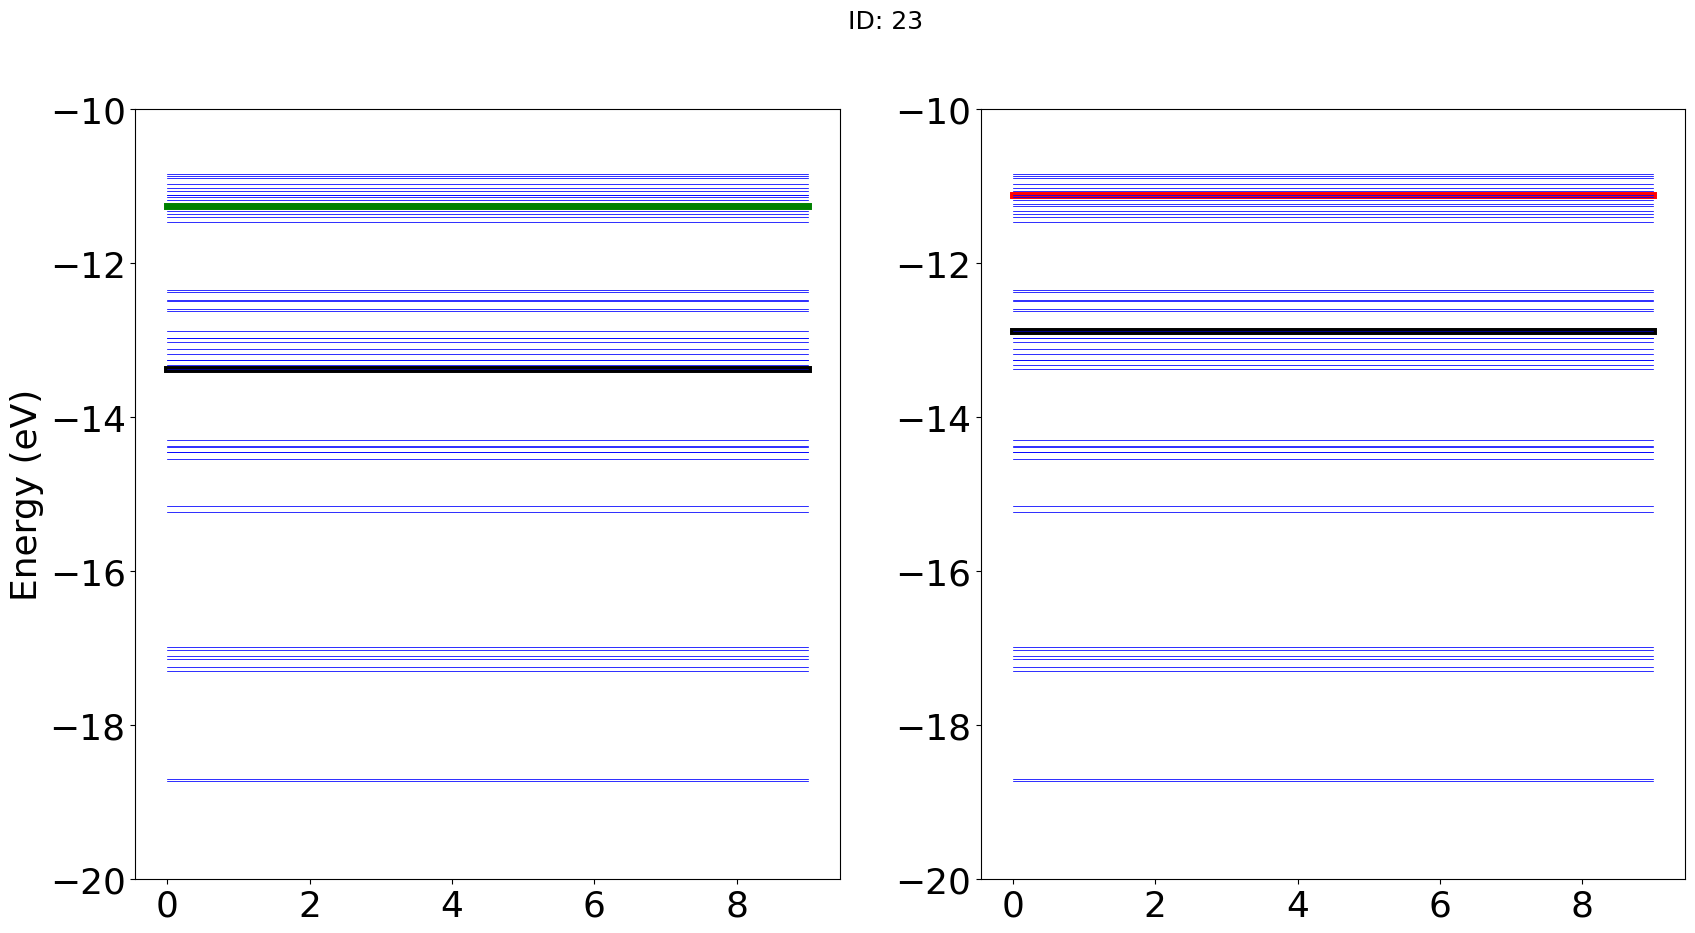

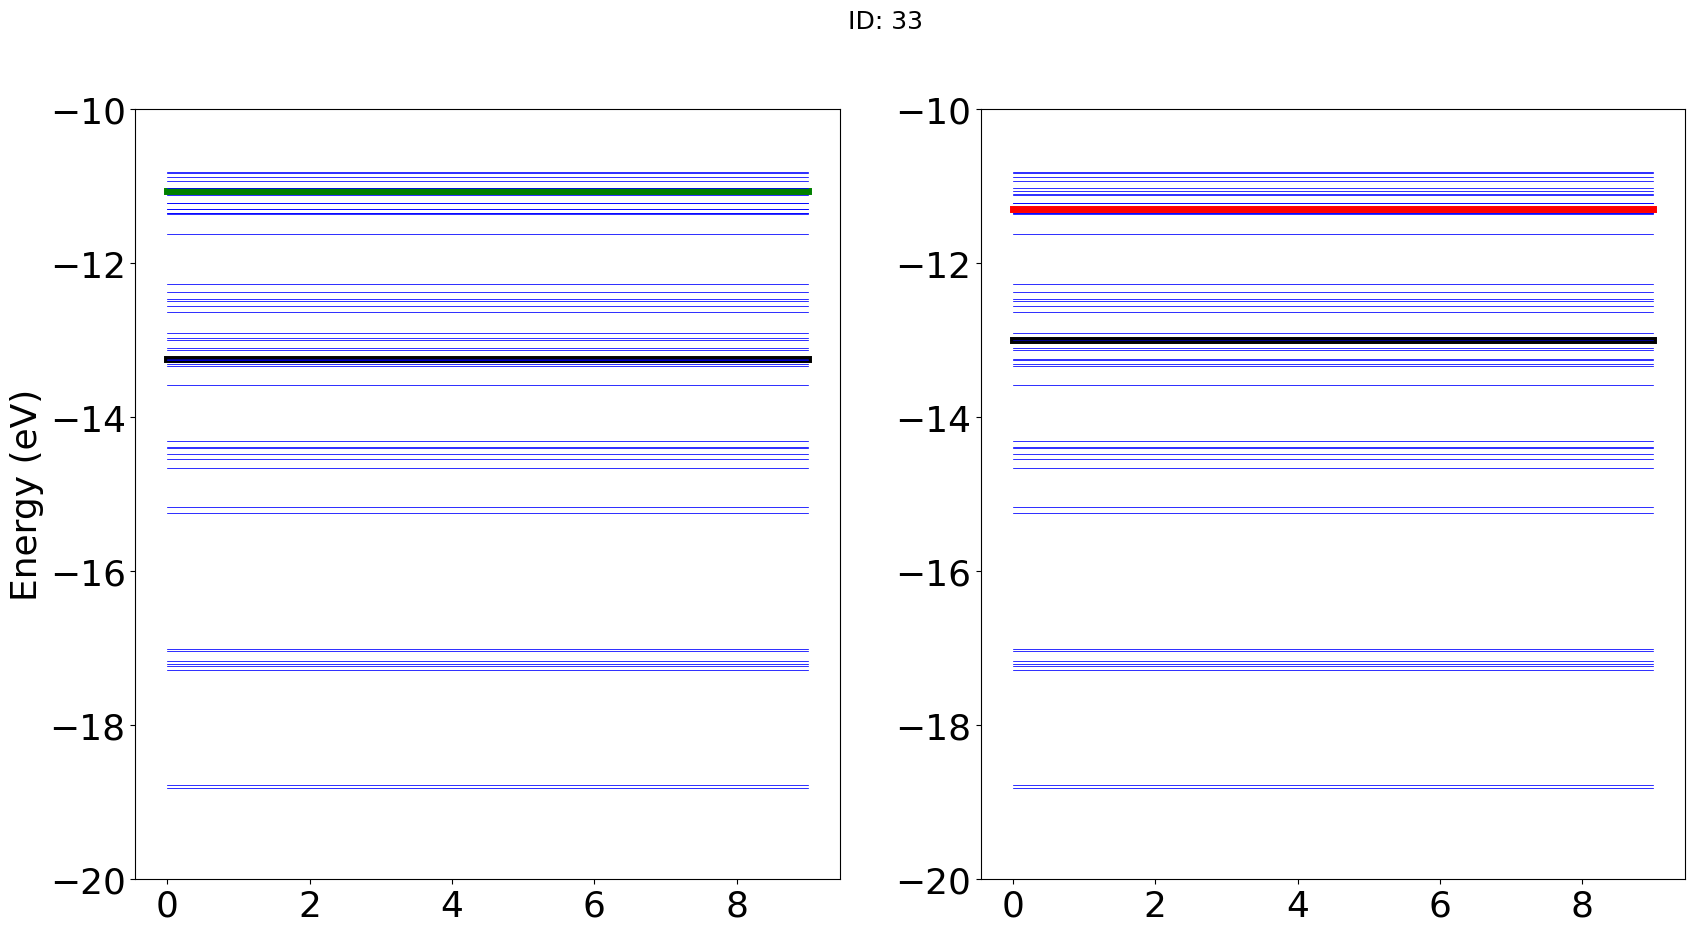

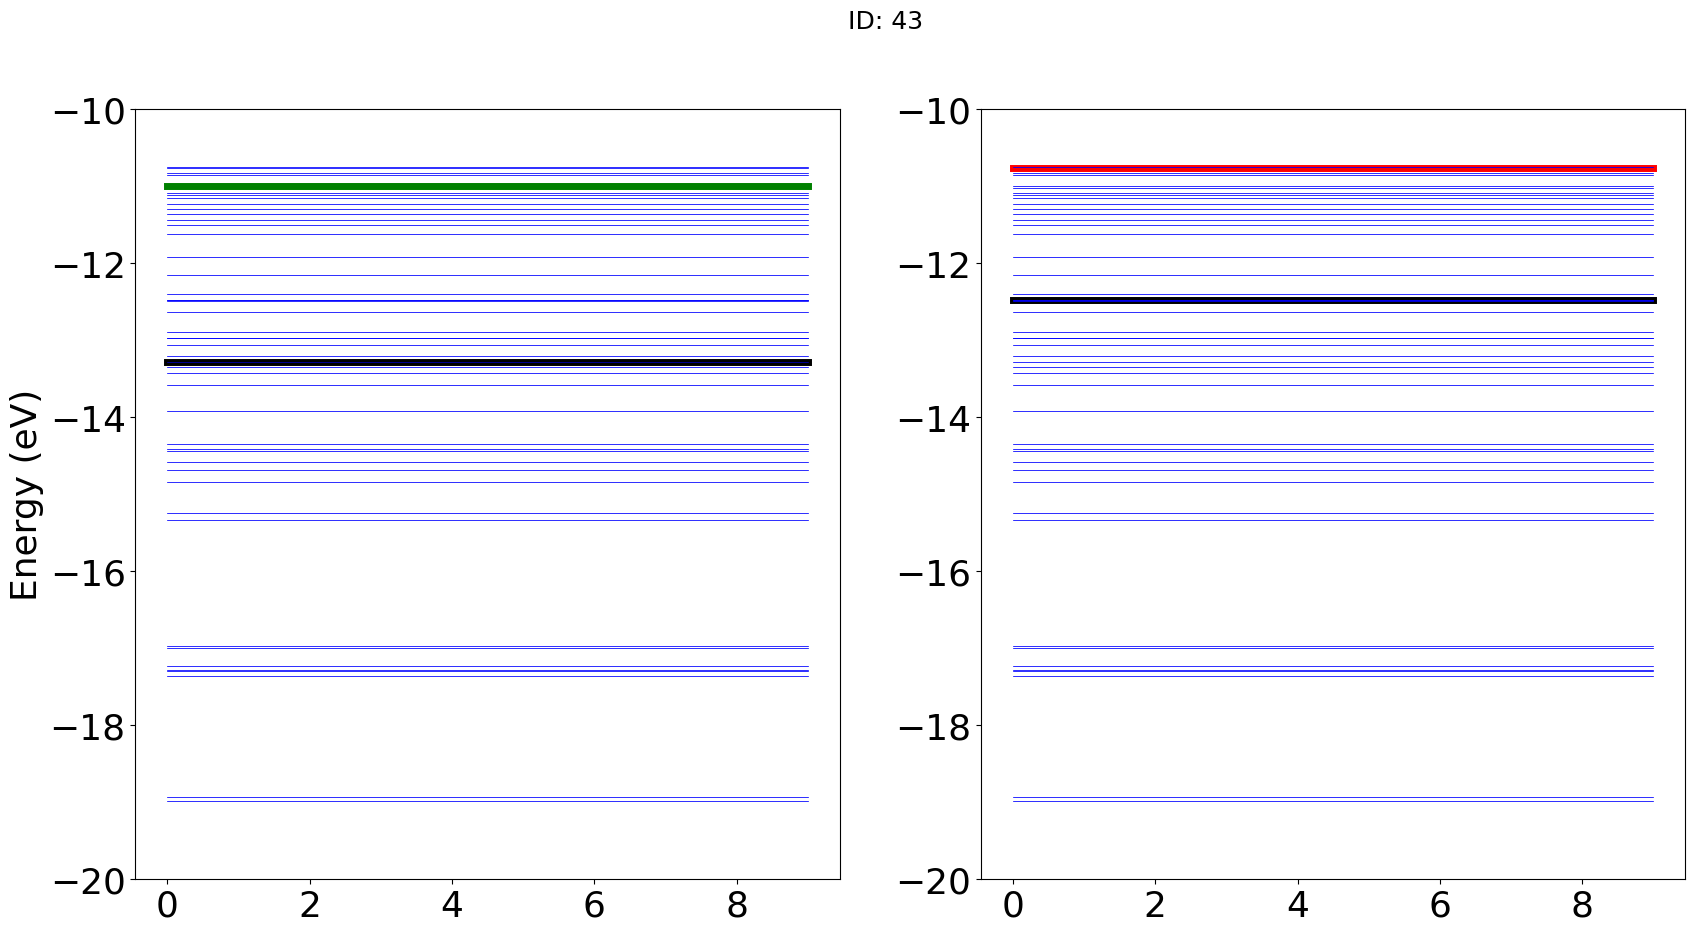

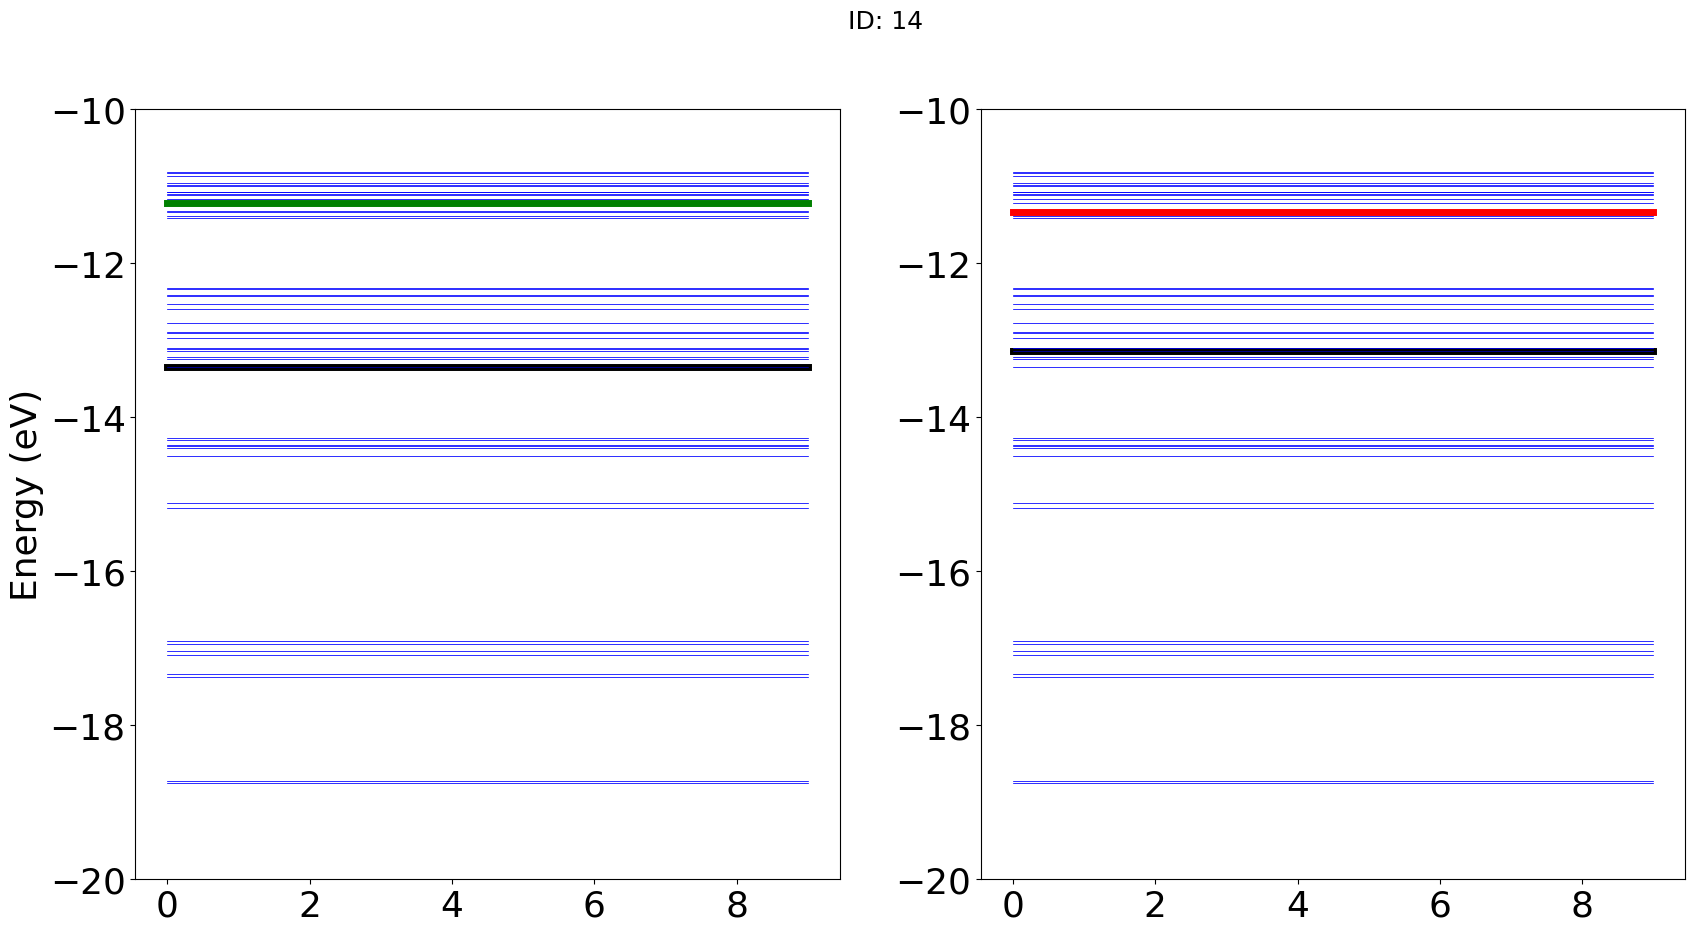

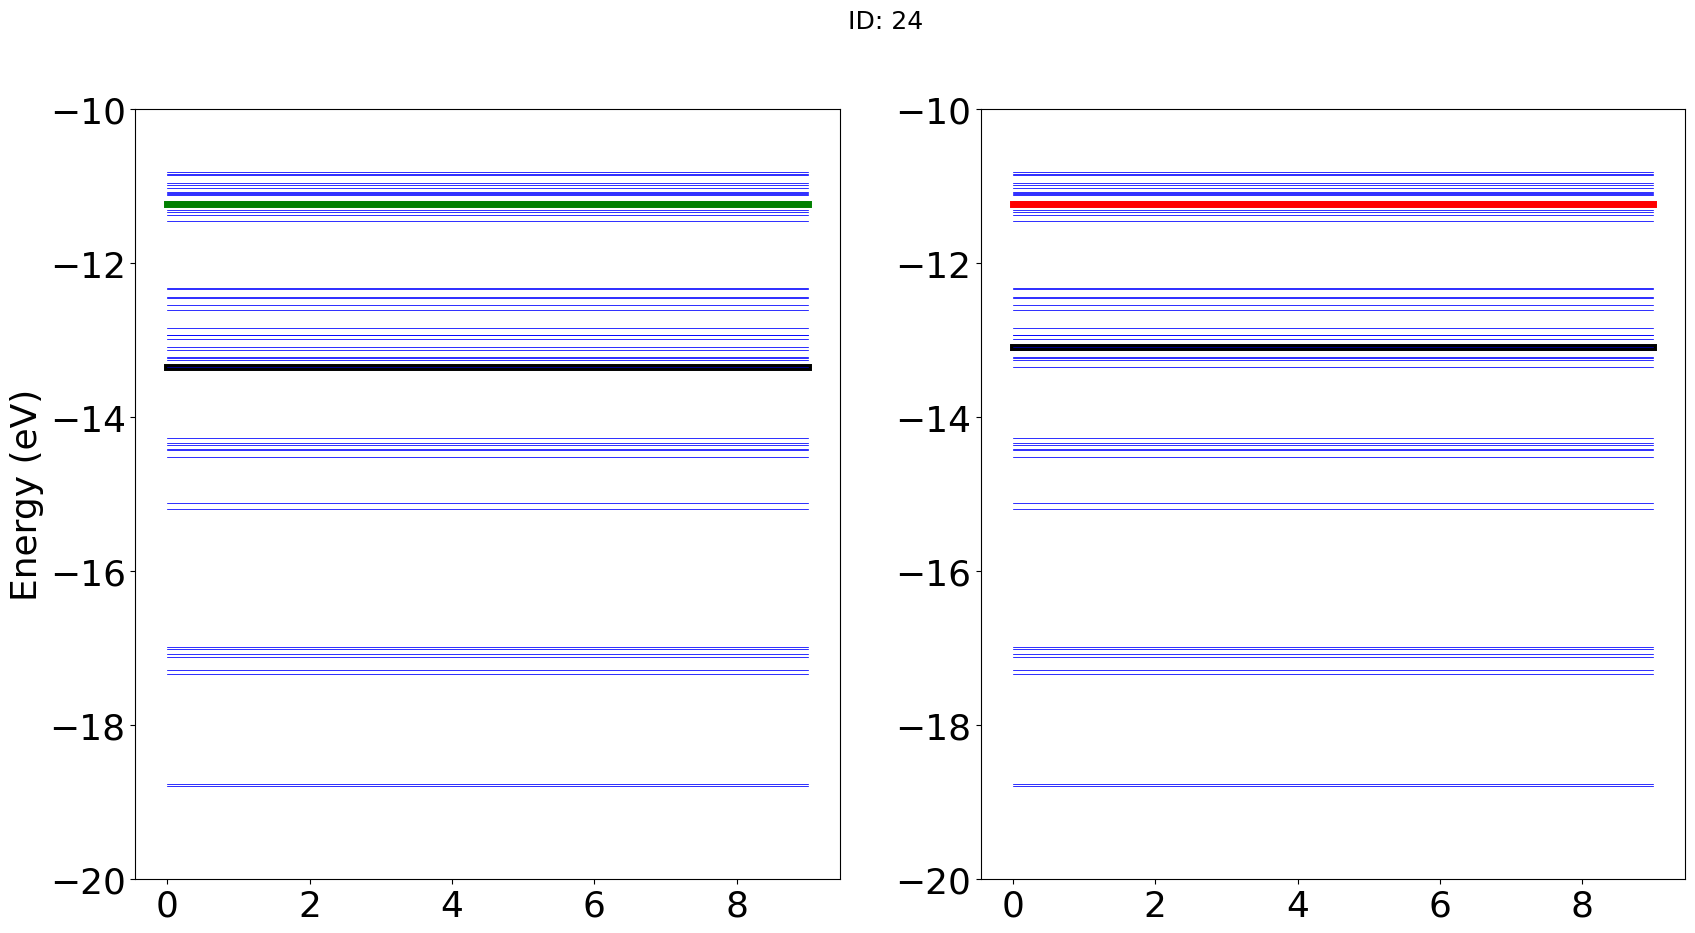

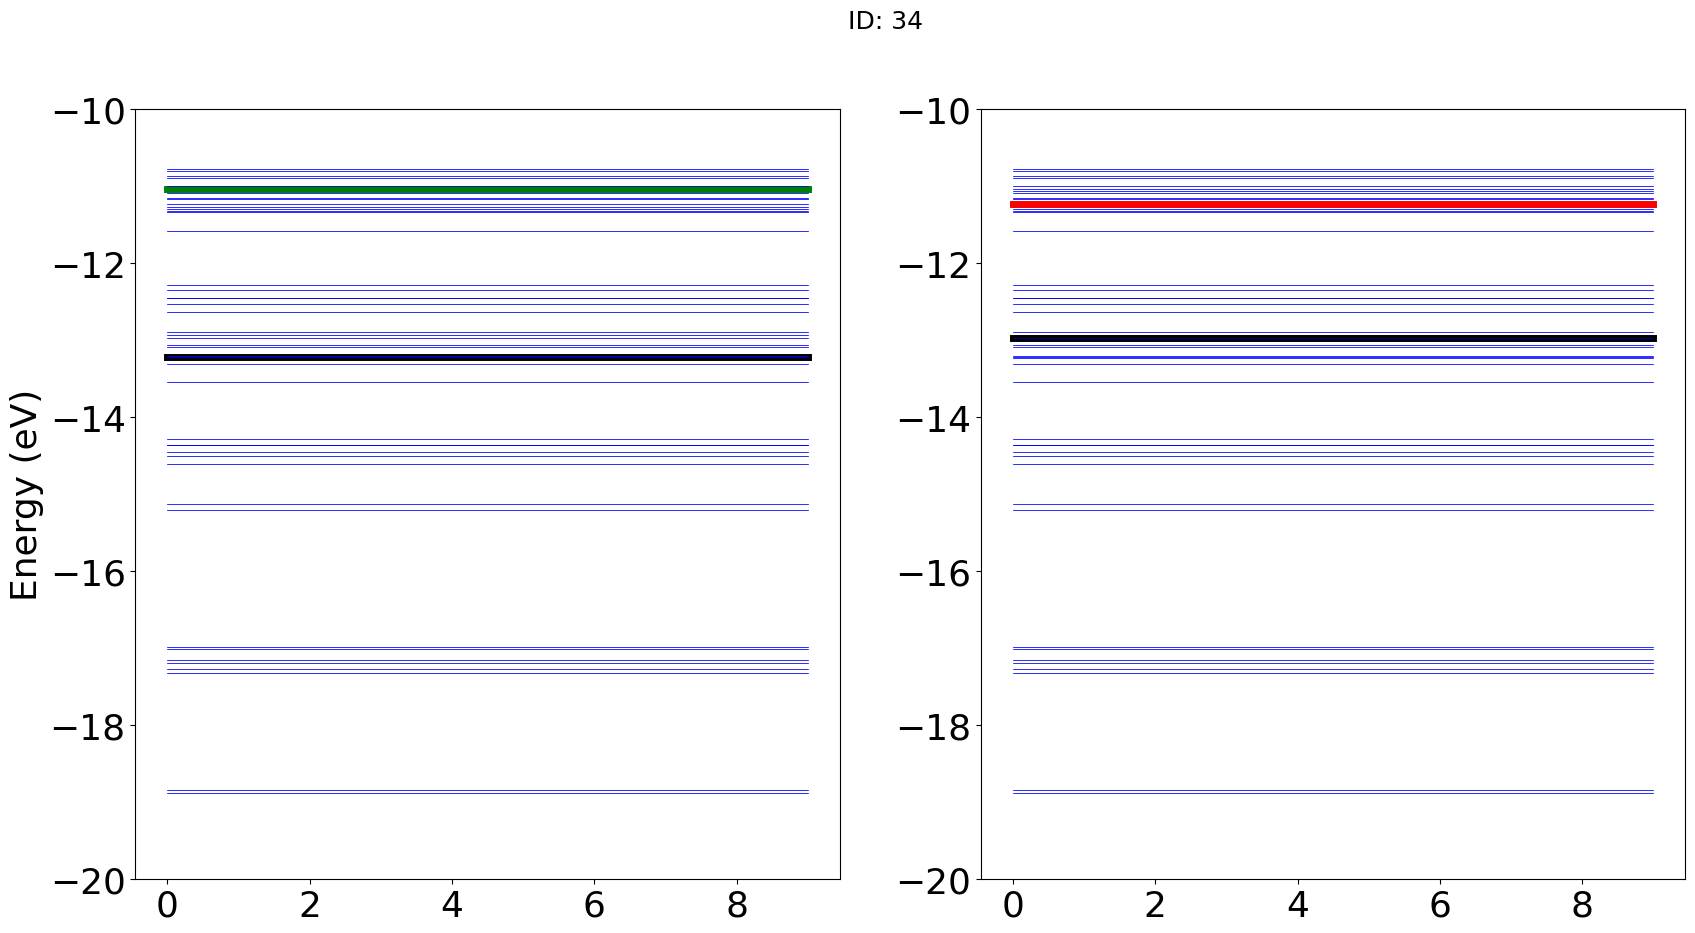

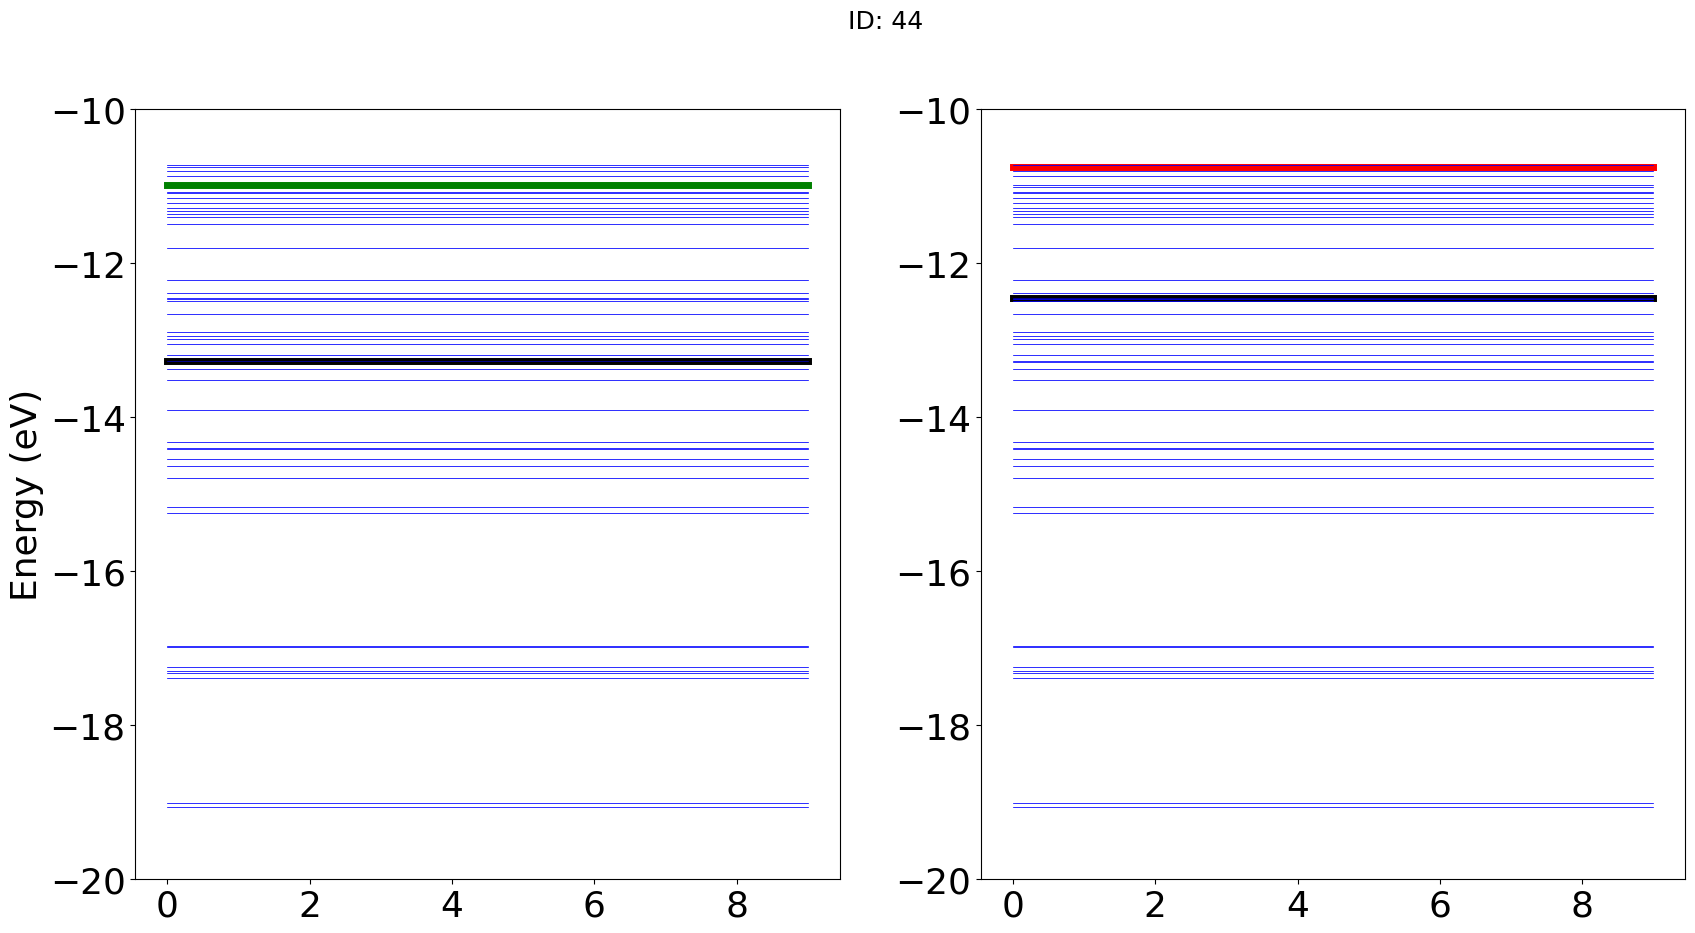

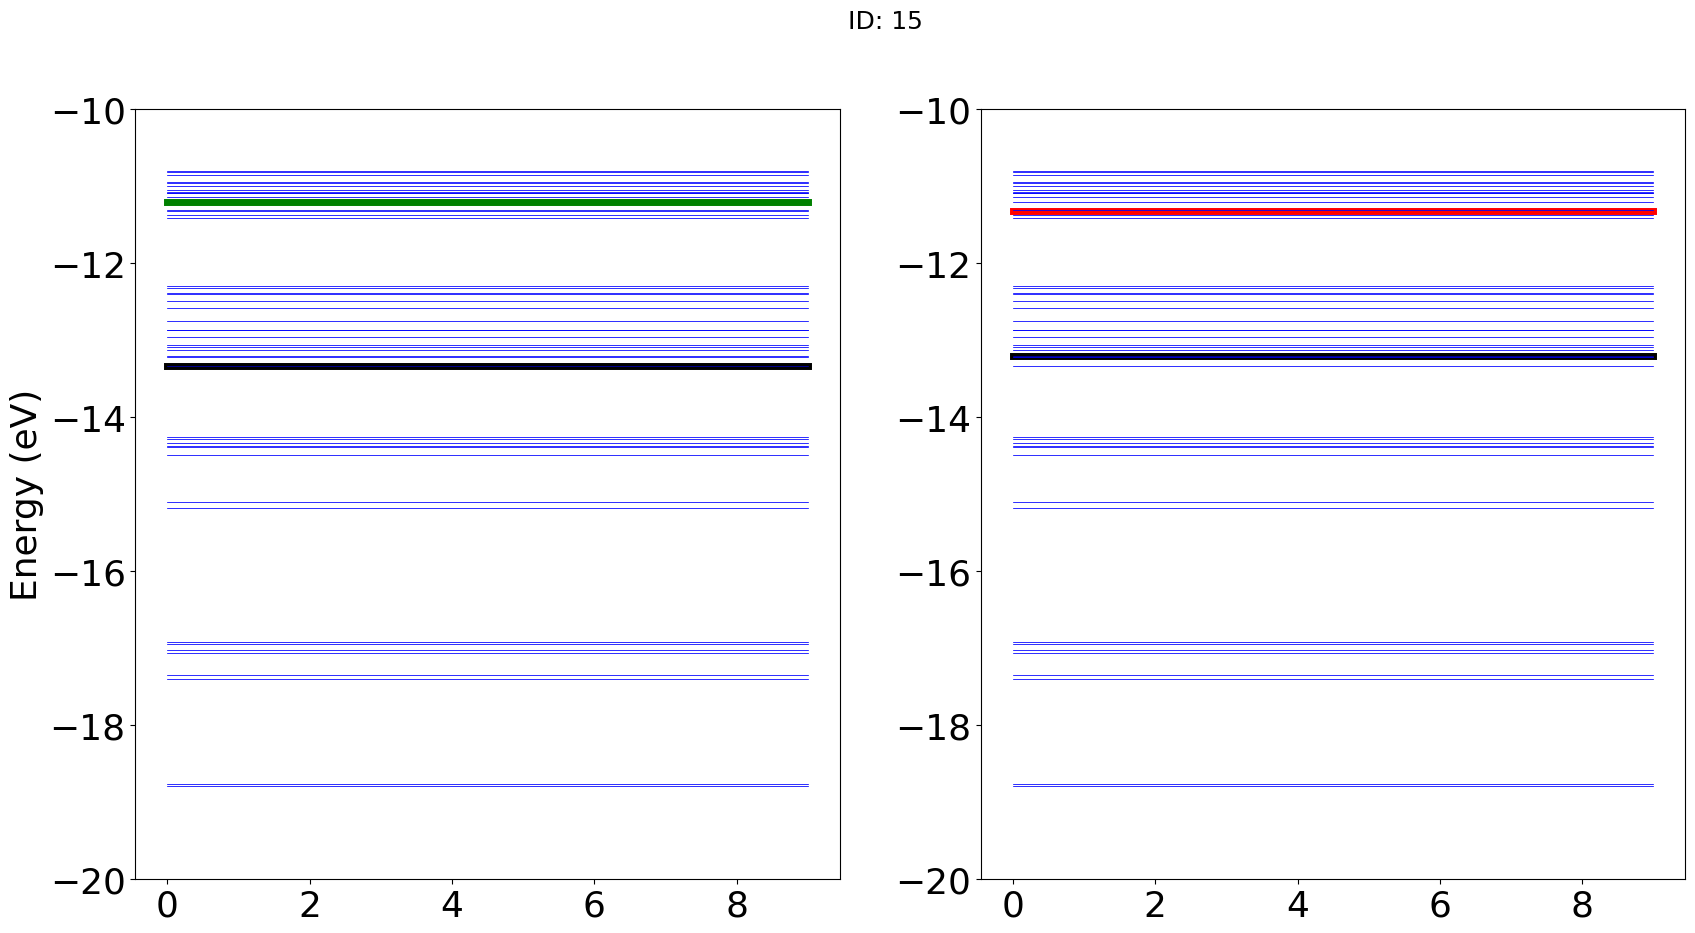

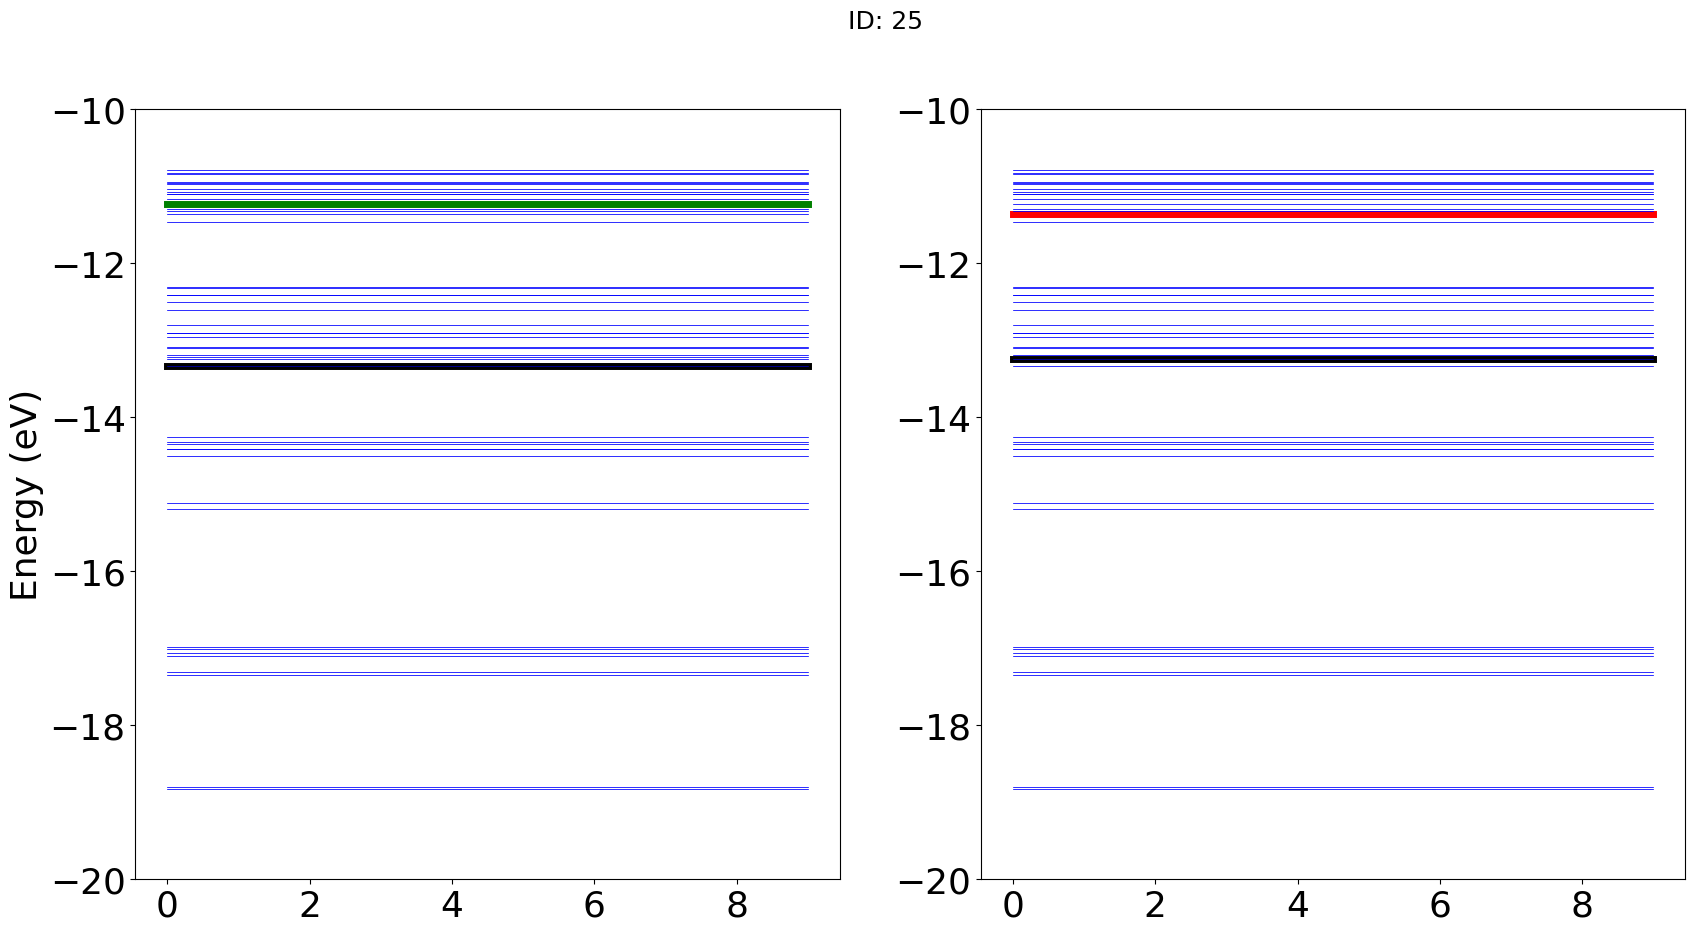

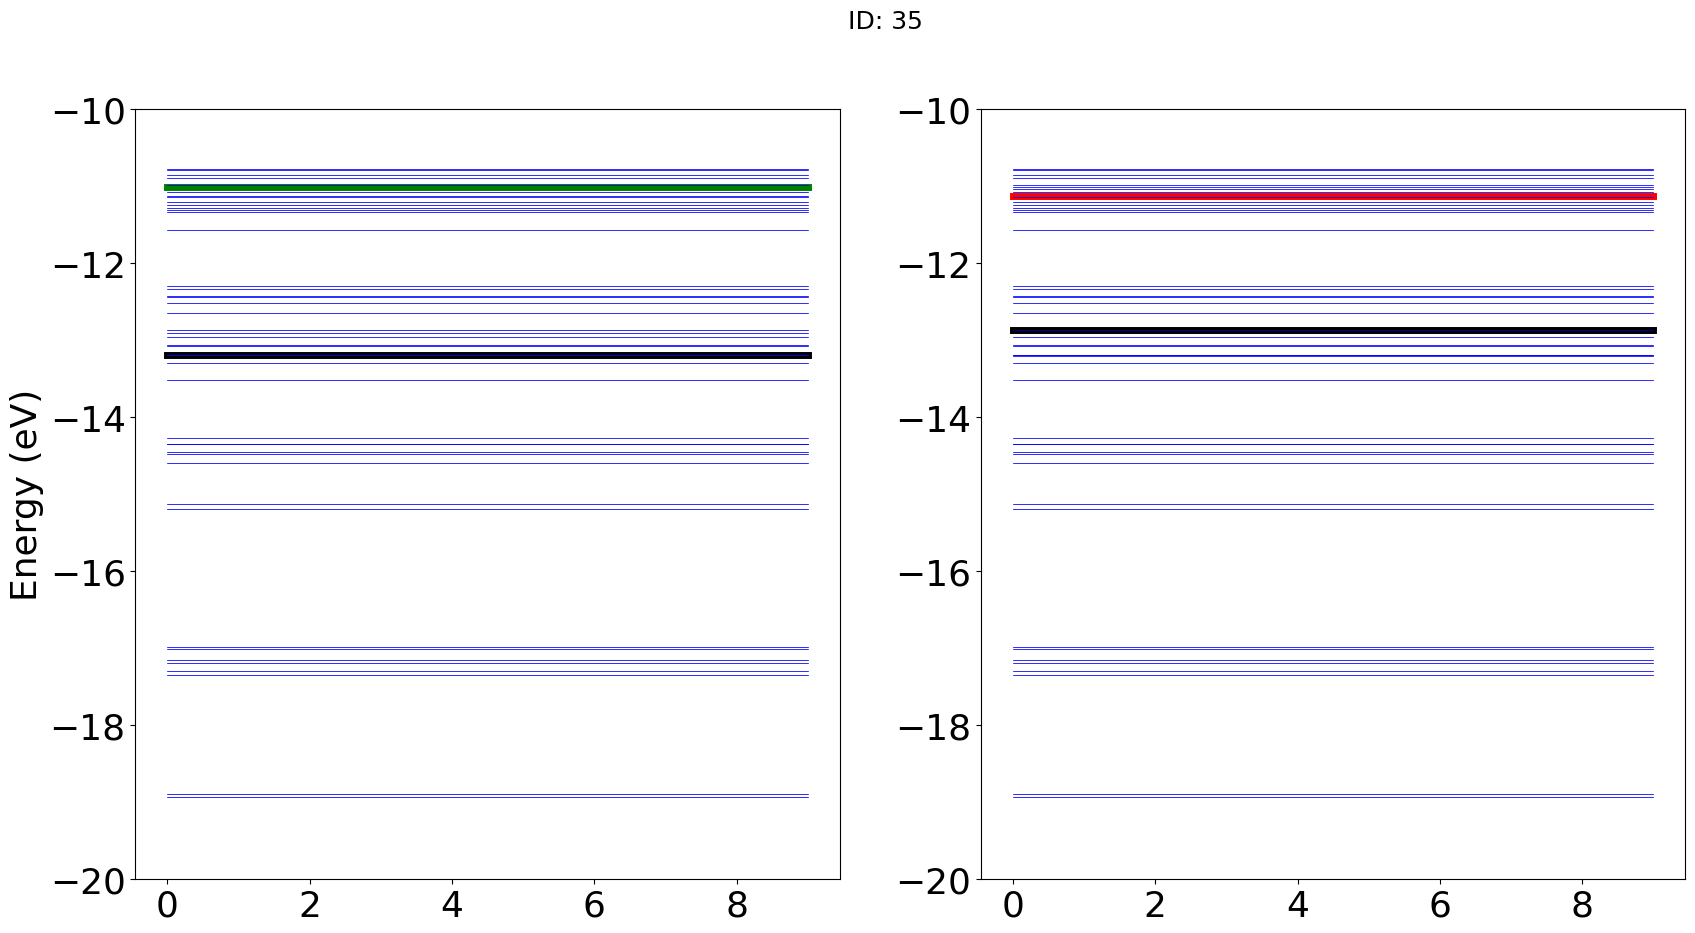

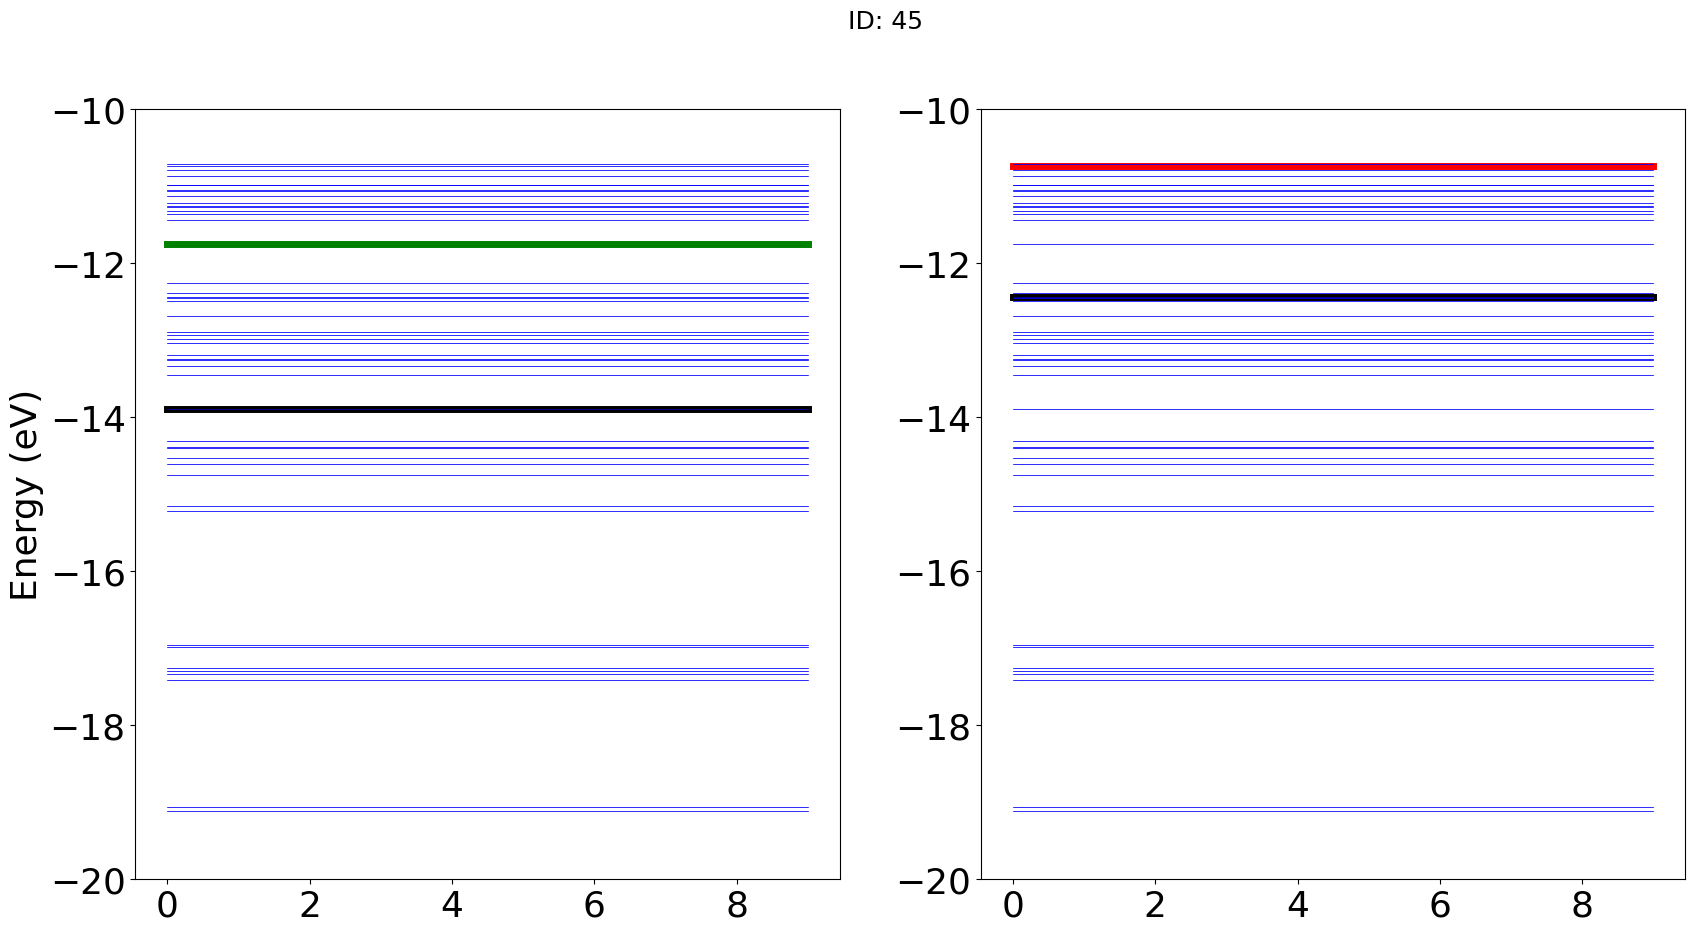

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [4]:
#figure(figsize=(20, 10))
for (ValidPairsGreen, ValidPairsRed) in zip(AllValidPairsGreen, AllValidPairsRed)
    figure(figsize=(20, 10))
    id = ValidPairsGreen[1]
    suptitle("ID: $id")
    #id == "41" || continue
    eigenvalsup = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[1:48]*eV
    eigenvalsdn = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[49:96]*eV
    momenta = np.reshape(abs.(np.fromfile("$dir_nohybrid/STH2$(id).momenta", dtype=np.complex )), (2, 3, 48, 48));
    maxgreen = argmax([v[4] for v in ValidPairsGreen[2]])
    maxred = argmax([v[4] for v in ValidPairsRed[2]])

    #println("Max Green Oscillator Strength: ", [v[4] for v in ValidPairsGreen[2]][maxgreen])
    #println("Max Red Oscillator Strength: ", [v[4] for v in ValidPairsRed[2]][maxred])
    subplot(1, 2, 1)
    for i in 1:48
        ((i == ValidPairsGreen[2][maxgreen][2]) && (ValidPairsGreen[2][maxgreen][1] == 1))  ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="black", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4);
        ((i == ValidPairsGreen[2][maxgreen][3]) && (ValidPairsGreen[2][maxgreen][1] == 1)) ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="green", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4);
        ((i == ValidPairsGreen[2][maxgreen][2]) && (ValidPairsGreen[2][maxgreen][1] == 2))  ? plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="black", linewidth=5) : plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="blue", linewidth=.4);
        ((i == ValidPairsGreen[2][maxgreen][3]) && (ValidPairsGreen[2][maxgreen][1] == 2)) ? plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="green", linewidth=5) : plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="blue", linewidth=.4);
    end
    ylim(-20, -10)
    ylabel("Energy (eV)")
    subplot(1, 2, 2)
    for i in 1:48
        ((i == ValidPairsRed[2][maxred][2]) && (ValidPairsRed[2][maxred][1] == 1))  ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="black", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4);
        ((i == ValidPairsRed[2][maxred][3]) && (ValidPairsRed[2][maxred][1] == 1)) ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="red", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="blue", linewidth=.4);
        ((i == ValidPairsRed[2][maxred][2]) && (ValidPairsRed[2][maxred][1] == 2))  ? plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="black", linewidth=5) : plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="blue", linewidth=.4);
        ((i == ValidPairsRed[2][maxred][3]) && (ValidPairsRed[2][maxred][1] == 2)) ? plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="red", linewidth=5) : plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="blue", linewidth=.4);
    end
    ylim(-20, -10)
end

Peaks for id: 11: [735.2234084618426, 544.7136370294419, 349.96800301148124, 173.42536025742666, 148.69092363054776, 136.06878887669228]
Peaks for id: 21: [726.8881939014856, 554.1290418715541, 350.9257336982165, 174.84413935775072, 148.86353628757857, 137.08703505732296]
Peaks for id: 31: [789.5456475583863, 500.1022054868208, 347.1259217772799, 178.24665676077265, 150.78906820209227, 138.7182930468517]
Peaks for id: 41: [676.9998179501183, 440.0378653413797, 321.0532677199344, 181.27029003168414, 156.1126736912808, 140.2353118636398]
Peaks for id: 12: [743.752, 549.3810016250554, 350.9257336982165, 175.3222384611758, 150.78906820209227, 135.63701353175037]
Peaks for id: 22: [756.9224506411562, 554.1290418715541, 349.96800301148124, 176.7723534724533, 151.144529344822, 136.06878887669228]
Peaks for id: 32: [770.5677579776212, 547.0373639305678, 343.407516852895, 180.75924755747826, 152.947273175948, 136.9406392694064]
Peaks for id: 42: [702.9792060491494, 542.409568261377, 339.7679305

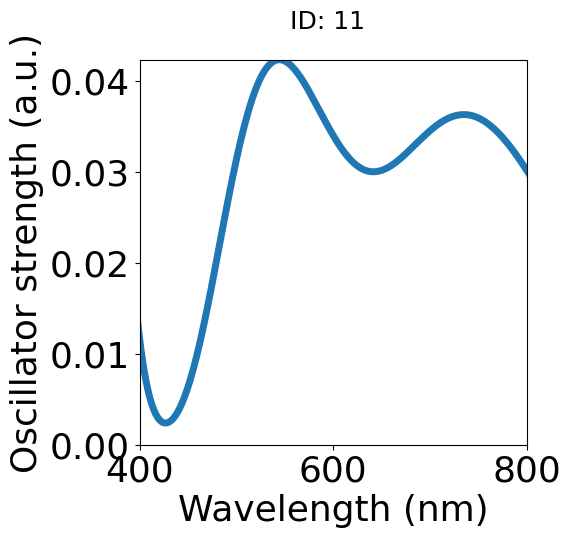

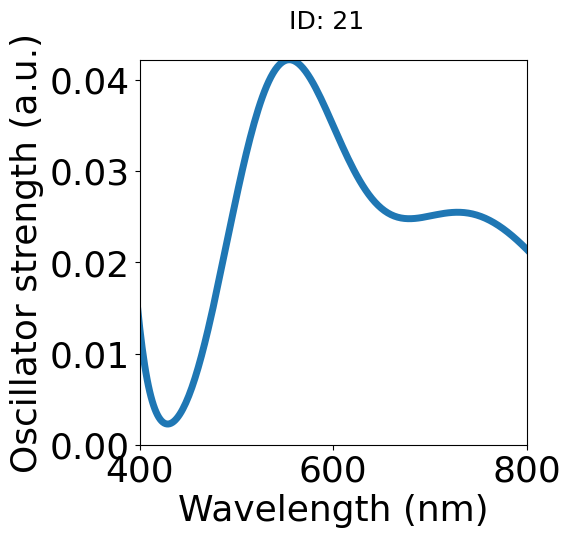

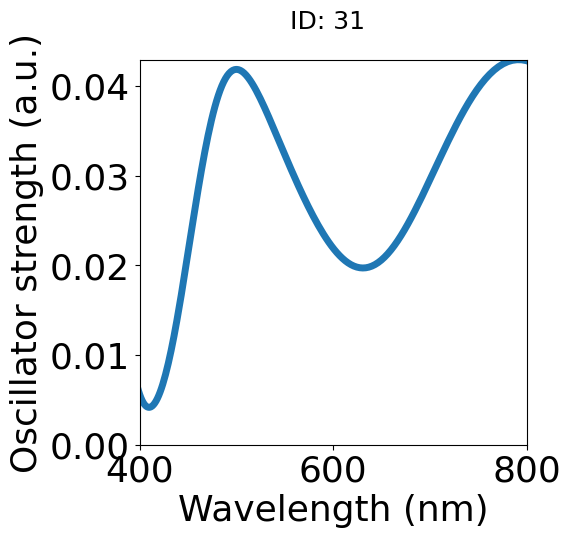

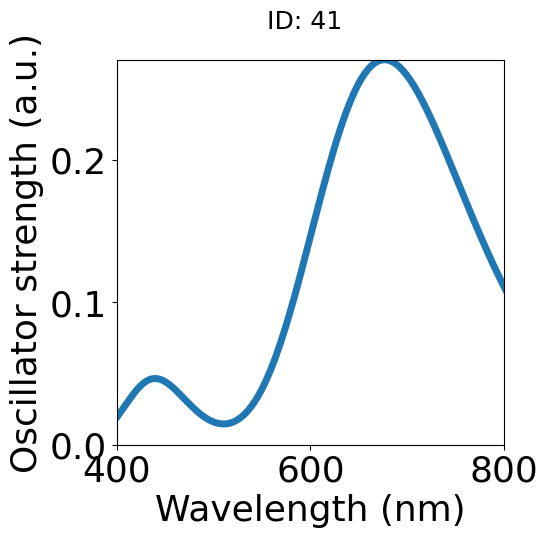

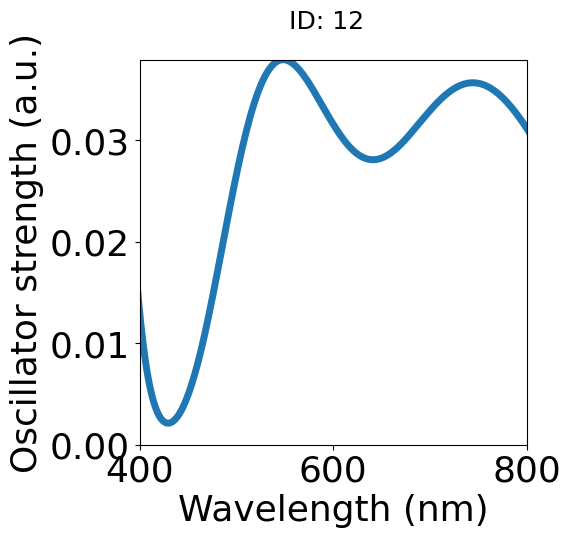

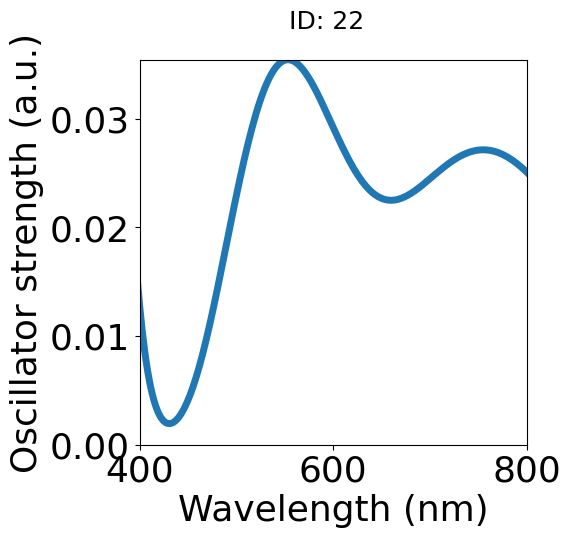

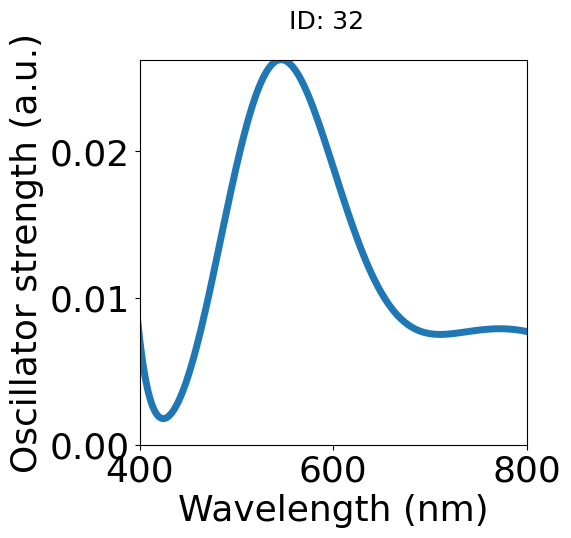

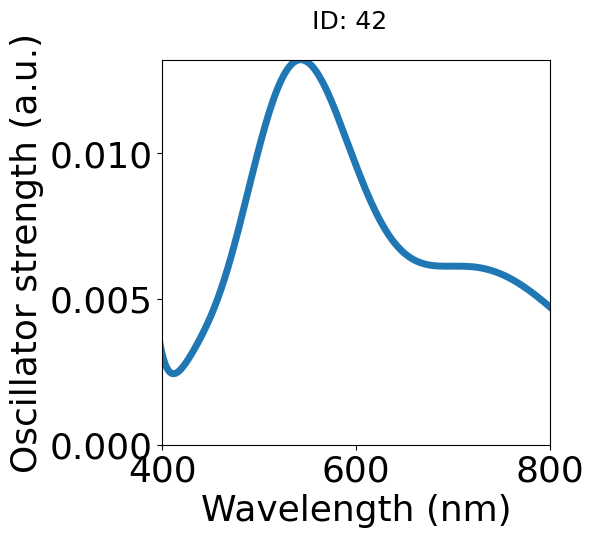

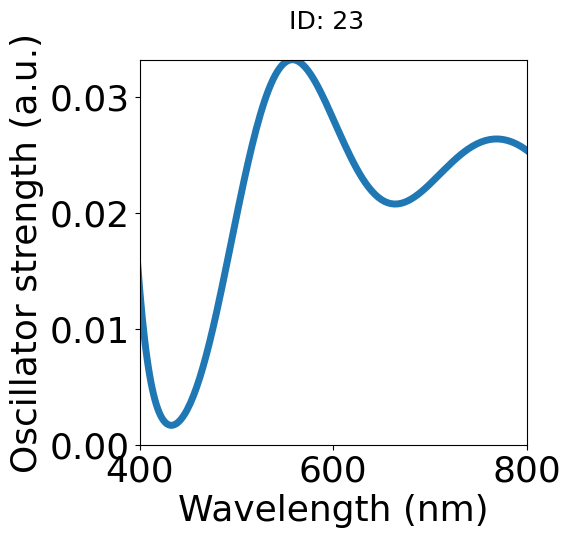

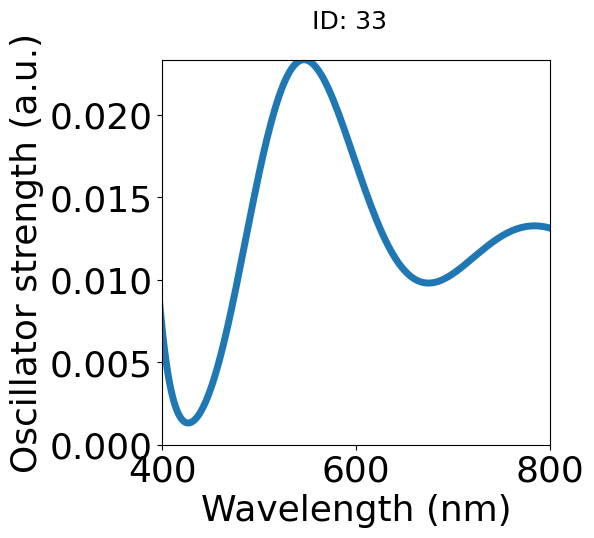

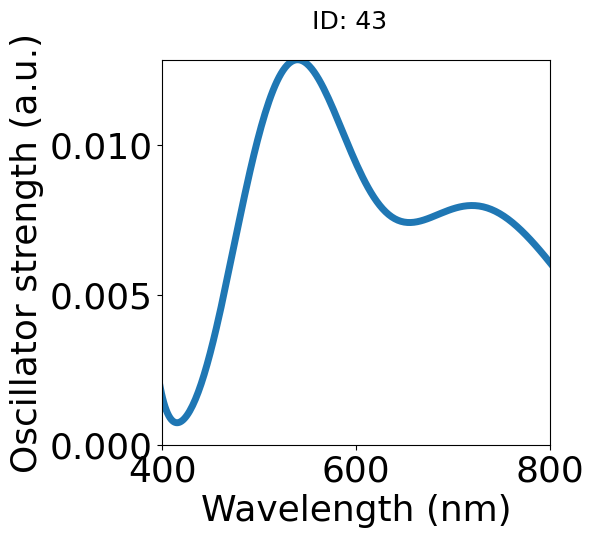

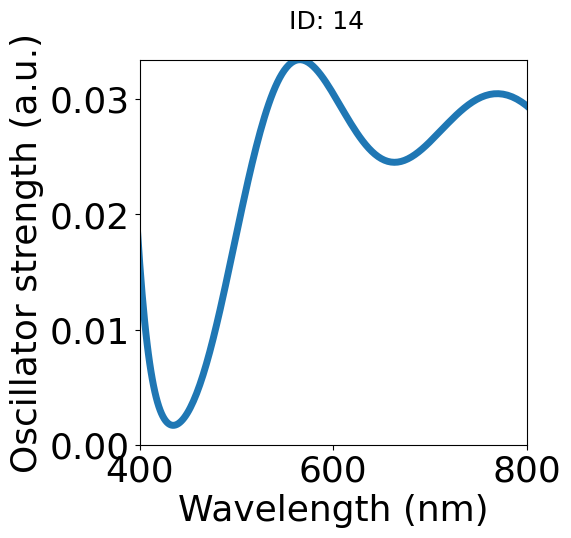

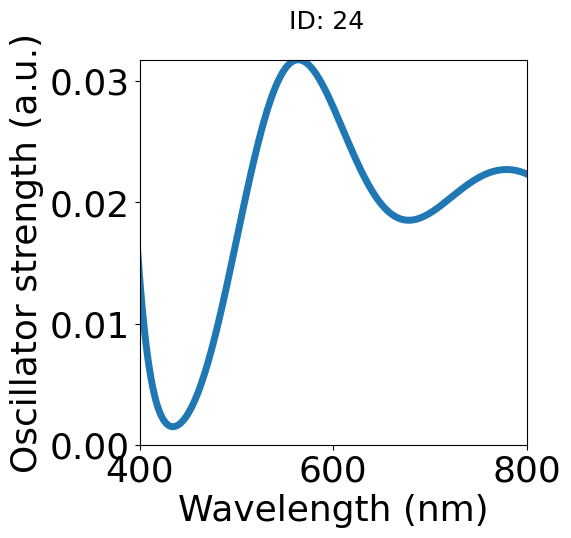

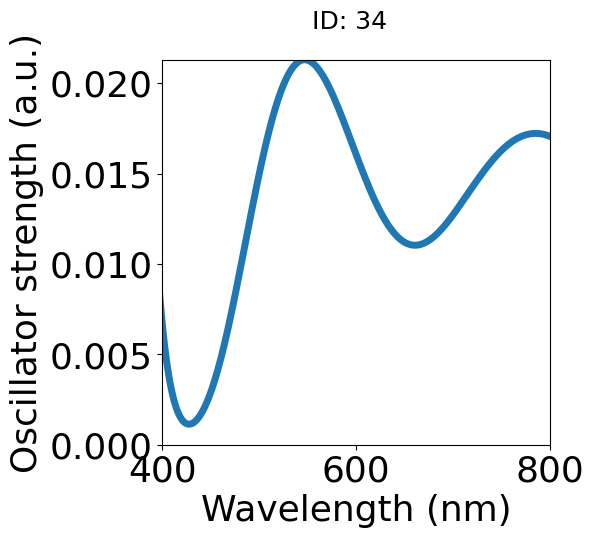

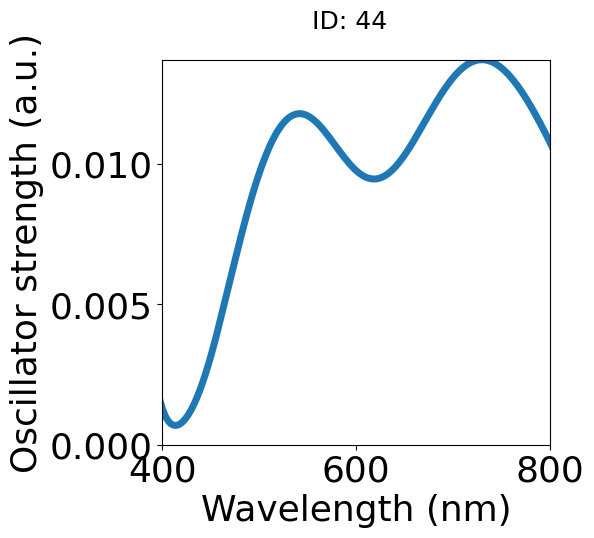

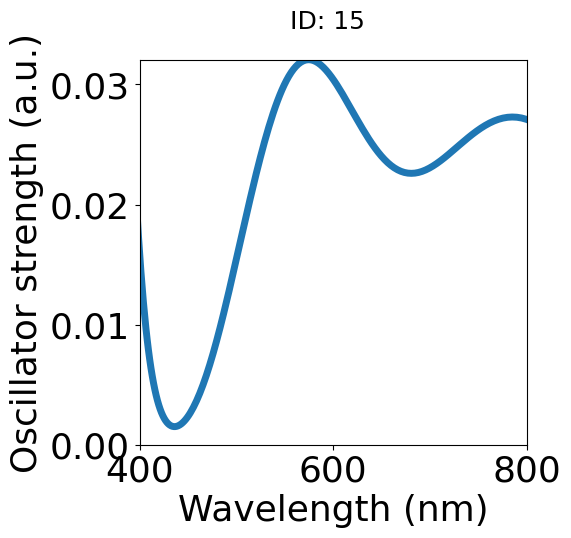

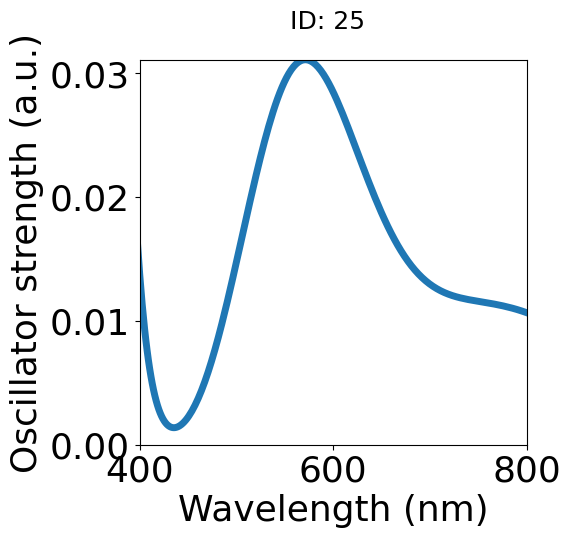

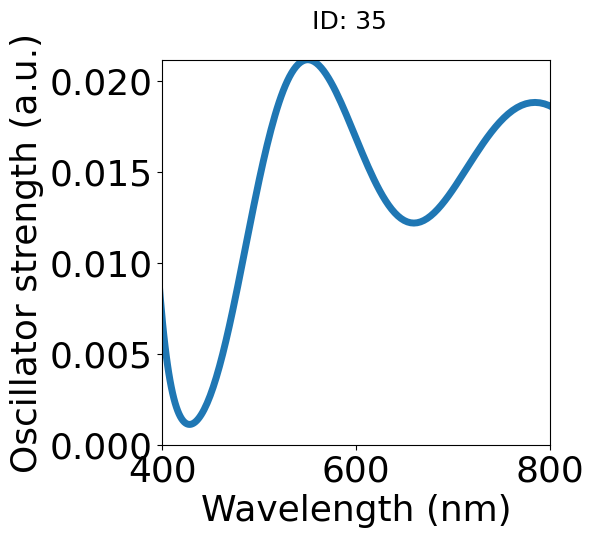

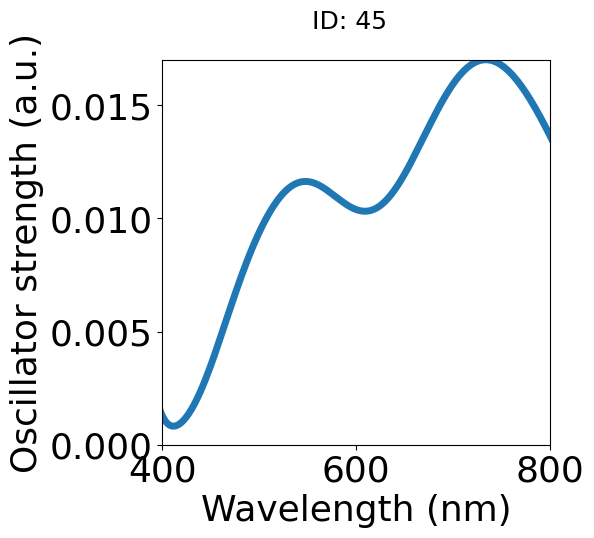

[571.4136447449292, 350.9257336982165, 183.34368683133658, 155.35614320925762, 135.4936967135466]
Peaks for id: 35: [784.7140746993036, 549.3810016250554, 340.6705753023085, 187.911066195048, 157.45448386823608, 136.06878887669228]
Peaks for id: 45: [735.2234084618426, 547.0373639305678, 322.6689804772234, 195.65212816330825, 161.82593559617058, 136.79455582122495]


In [5]:
energies = collect(range(1, 30, length=3000))
lambdas = 1240 ./ collect(range(1, 30, length=3000))
broadening=0.2

for (ValidPairsGreen, ValidPairsRed) in zip(AllValidPairsGreen, AllValidPairsRed)
    figure(figsize=(5, 5))
    id = ValidPairsGreen[1]
    suptitle("ID: $id")
    FSTH2=zeros(100*30)
    eigenvalsup = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[1:48]*eV
    eigenvalsdn = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[49:96]*eV
    momenta = np.reshape(abs.(np.fromfile("$dir_nohybrid/STH2$(id).momenta", dtype=np.complex )), (2, 3, 48, 48));
    μ=0 
    for l in readlines("$dir_nohybrid/STH2$(id).eigStats")
        if VERSION.minor >= 5  
            contains(l, "mu" ) || continue ;
        elseif VERSION.minor < 5
            occursin("mu", l) || continue ;
        end
        μ = parse(Float64, l[6:end]);
    end
    for e1iter in 10:19
        for e2iter in 20:30
            e2iter > e1iter || continue
            eigup2 = eigenvalsup[e2iter]
            eigup1 = eigenvalsup[e1iter]
            eigdn2 = eigenvalsdn[e2iter]
            eigdn1 = eigenvalsdn[e1iter]

            ediffup = (eigup2-eigup1)
            ediffdn = (eigdn2-eigdn1)
            momentaup_squared = sum((abs.(momenta[1, :, e1iter, e2iter])).^2)
            momentadn_squared = sum((abs.(momenta[2, :, e1iter, e2iter])).^2)
            f = (1-np.heaviside(μ*eV-eigup2, 0.5))*(np.heaviside(μ*eV-eigup1, 0.5))
            f *= 2/3*(1/ediffup)*(momentaup_squared)
            FSTH2 += f*exp.(-0.5*(energies.-ediffup).^2/(broadening)^2)
            f = (1-np.heaviside(μ*eV-eigdn2, 0.5))*(np.heaviside(μ*eV-eigdn1, 0.5))
            f *= 2/3*(1/ediffdn)*(momentadn_squared)
            FSTH2 += f*exp.(-0.5*(energies.-ediffdn).^2/(broadening)^2)
        end
    end
    FSTH2 *= eV
    plot(lambdas, FSTH2, linewidth=5)
    ylabel("Oscillator strength (a.u.)")
    xlabel("Wavelength (nm)")
    xlim(400,800)
    ylim(0, maximum(FSTH2[argmin(abs.(lambdas .-800)):argmin(abs.(lambdas .- 400))]))
    println("Peaks for id: $id: ", lambdas[argmaxima(FSTH2)])
end
